In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams.update({'font.size': 12})

from scipy import signal 
from scipy import stats
import itertools
import seaborn as sns
import statsmodels.api as sm
import random

In [2]:
import pickle
import json
json_open = open('../../dj_local_conf.json', 'r') 
config = json.load(json_open)

import datajoint as dj
dj.config['database.host'] = config["database.host"]
dj.config['database.user'] = config ["database.user"]
dj.config['database.password'] = config["database.password"]
dj.conn().connect()

from pipeline import lab, get_schema_name, experiment, foraging_model, ephys, foraging_analysis, histology, ccf
from pipeline.plot import unit_psth
from pipeline.plot.foraging_model_plot import plot_session_model_comparison, plot_session_fitted_choice
from pipeline import psth_foraging
from pipeline import util
from pipeline.model import bandit_model

/home/map/.local/lib/python3.6/site-packages/pymysql/_auth.py:8: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography and will be removed in a future release.
  from cryptography.hazmat.backends import default_backend


Connecting pochen@datajoint.mesoscale-activity-map.org:3306


### Implementation by Kenneth

In [2]:
def ridge_error(x, y, r=0):
    ''' ridge_error(x, y, lambda):
    predicts y [n by m] from x [n by p] by ridge regression. 
    
    Returns:
    * fit error as a frac of variance (scalar), 
    * weight [p by m], 
    * prediction [N by m].
    '''
    
    # append to bottom of matrices to make ridge regression
    n = x.shape[0]
    p = x.shape[1]
    m = y.shape[1]
    x0 = np.block([[x, np.ones([n,1])]])
    x1 = np.block([[x, np.ones([n,1])], [r*np.eye(p), np.zeros([p,1])]])
    y1 = np.block([[y], [np.zeros((p,m))]])
    w, _, _, _ = np.linalg.lstsq(x1, y1, rcond=None)
    y_hat = x0@w
    return np.mean((y-y_hat)**2)/np.var(y), w, y_hat

#ridge_error(np.array([[1],[0]]),np.array([[2],[1]]),1e10)

In [3]:
class Bunch(dict):
    """A subclass of dictionary with an additional dot syntax."""

    def __init__(self, *args, **kwargs):
        super(Bunch, self).__init__(*args, **kwargs)
        self.__dict__ = self

    def copy(self):
        """Return a new Bunch instance which is a copy of the current Bunch instance."""
        return Bunch(super(Bunch, self).copy())

In [4]:
# parameters for noise process with block target
params_B = Bunch(
    T = 200,  # number of trials
    C = 10,  # number of cells
    ex = 0,  # sd of amplitude of exponential components in sources
    exp_tc = 15,  # time constant of the exponentional components
    nx = 0.1,  # amp of colored noise in sources
    tx = 0,  # sd of amplitude of target in sources
    wx = 0,  # sd of white noise in sources
    shift_rate = 2,  # expected number of shifts during the recording, for each cell
    shift_width = 10,  # width of shifts
    target_noise = False,  # if true, target is pink noise series rather than blocks
    target_shift_amp = 1,  # add a random shift component to target, with this amplitude (only if noise)
    signal_f_tc = False,  # filter target with this timecourse before adding to x. False:don't
    bl = 50,  # target block length, if target is blocks
    blrand = 20,  # block length add random between 0 and this
    tau = 5000.0,  # time constant of pink noise (trials)
    noise_nonlin = 1,  # apply this power to the noise signal to make a nonlinear time series. 1 means linear
    blocks_stationary = False  # shift blocks randomly to make them stationary?
)

# with noise target
params_N = Bunch(params_B)
params_N.target_noise = True

#with actual predictability
params_B1 = Bunch(params_B)
params_B1.tx = .1
params_N1 = Bunch(params_N)
params_N1.tx = 1

param_list = (params_B, params_N, params_B1, params_N1)
n_params = len(param_list)

seed = 5
R = 1000  # number of repeats
N = 500  # number of resamples for p value

In [5]:
def make_shift_sequence(T, C, rate, width, pad=1):
    ''' make a timeseries of logistic shifts occuring at poisson times, of +-1 amplitude 
    (T, C): output size. 
    rate: expected number of shifts per cell. 
    width: logistic width
    pad(=1): what multiple of window to subset from (to make stationary)
    '''
    
    long_seq = np.zeros((pad*T, C))
    for c in range(C):
        shift_times = np.random.choice(pad*T, np.random.poisson(rate*pad))
        for t in shift_times:
            sign = np.sign(np.random.rand(1)-.5)
            long_seq[:,c] += 1/(1+np.exp(sign*(np.arange(pad*T)-t)/width))
    return long_seq[T*(pad-1)//2 : T*(pad+1)//2 ]

def make_data(params):
    ''' returns x, y
    x: T by C array of analog signals [pink noise + exponential drift + linear + target]
    y: target signal: binary block or another noise
    '''

    # weights for each cell
    exp_wt = params.ex * np.random.randn(params.C) 
    y_wt = params.tx * np.random.randn(params.C)
    
    # parameters for filtered noise
    alpha = np.exp(-2.0/ params.tau)
    b = np.array([np.sqrt(1-alpha)])
    a = np.array([1, -np.sqrt(alpha)])
    
    # make filtered noise
    x0, _ =  signal.lfilter(b, a, np.random.randn(params.T, params.C), axis=0, zi=np.random.randn(1, params.C)) 
    
    x = params.nx * (x0**params.noise_nonlin) \
        + exp_wt[None, : ] * np.exp(-np.arange(params.T)[: , None]/params.exp_tc) \
        + params.wx * np.random.randn(params.T, params.C) \
        + make_shift_sequence(params.T, params.C, params.shift_rate, params.shift_width)
        
    if params.target_noise:
        y0, _ =  signal.lfilter(b,a, np.random.randn(params.T, 1), axis=0, zi=np.random.randn(1, 1)) 
        y = params.nx*(y0**params.noise_nonlin) \
            + make_shift_sequence(params.T, 1, params.shift_rate, params.shift_width)
    else: 
        # make blocks
        n_block = 1000 # way too many blocks, because we might randomize from it
        block_len = np.random.randint(params.bl, params.bl+params.blrand, n_block)
        flip_times = np.cumsum(block_len)
        y0 = np.cumsum(np.bincount(flip_times, (-1)**np.arange(n_block)))

        if params.blocks_stationary:
            start_point = np.random.randint(len(y0)//2)
            y = y0[start_point: start_point+params.T, None]
        else:
            y = y0[ :params.T, None]
    
    # now add part of target if needed
    if params.signal_f_tc:
        alpha2 = -np.exp(1.0/params.signal_f_tc)
        a2 = np.array([alpha2/(1+alpha2), 1/(1+alpha2)])  
        yf,_ = signal.lfilter([1],a2,y, axis=0, zi=-y[0,None]/alpha2)
        x += y_wt[None,:] * yf
    else:
        x += y_wt[None,:] * y
    
    # scale 0 to 1
    y = (y-y.min(0))/(y.max(0)-y.min(0))
    x = (x-x.min(0))/(x.max(0)-x.min(0))
    
    return x, y

In [6]:
# make data
# exampleData =[]
# for params in paramList:
#     np.random.seed(Seed)
#     exampleData.append(make_data(params))

test_data = []
for i, params in enumerate(param_list):
    np.random.seed(seed)
    test_data.append([])
    for r in range(R):
        test_data[i].append(make_data(params))

In [7]:
print(f'test_data categories: {len(test_data)}')
print(f'test_data repeats per category: {len(test_data[0])}')
print(f'test_data data point x: {test_data[0][0][0].shape}')  # trial by cell
print(f'test_data data point y: {test_data[0][0][1].shape}')

test_data categories: 4
test_data repeats per category: 1000
test_data data point x: (200, 10)
test_data data point y: (200, 1)


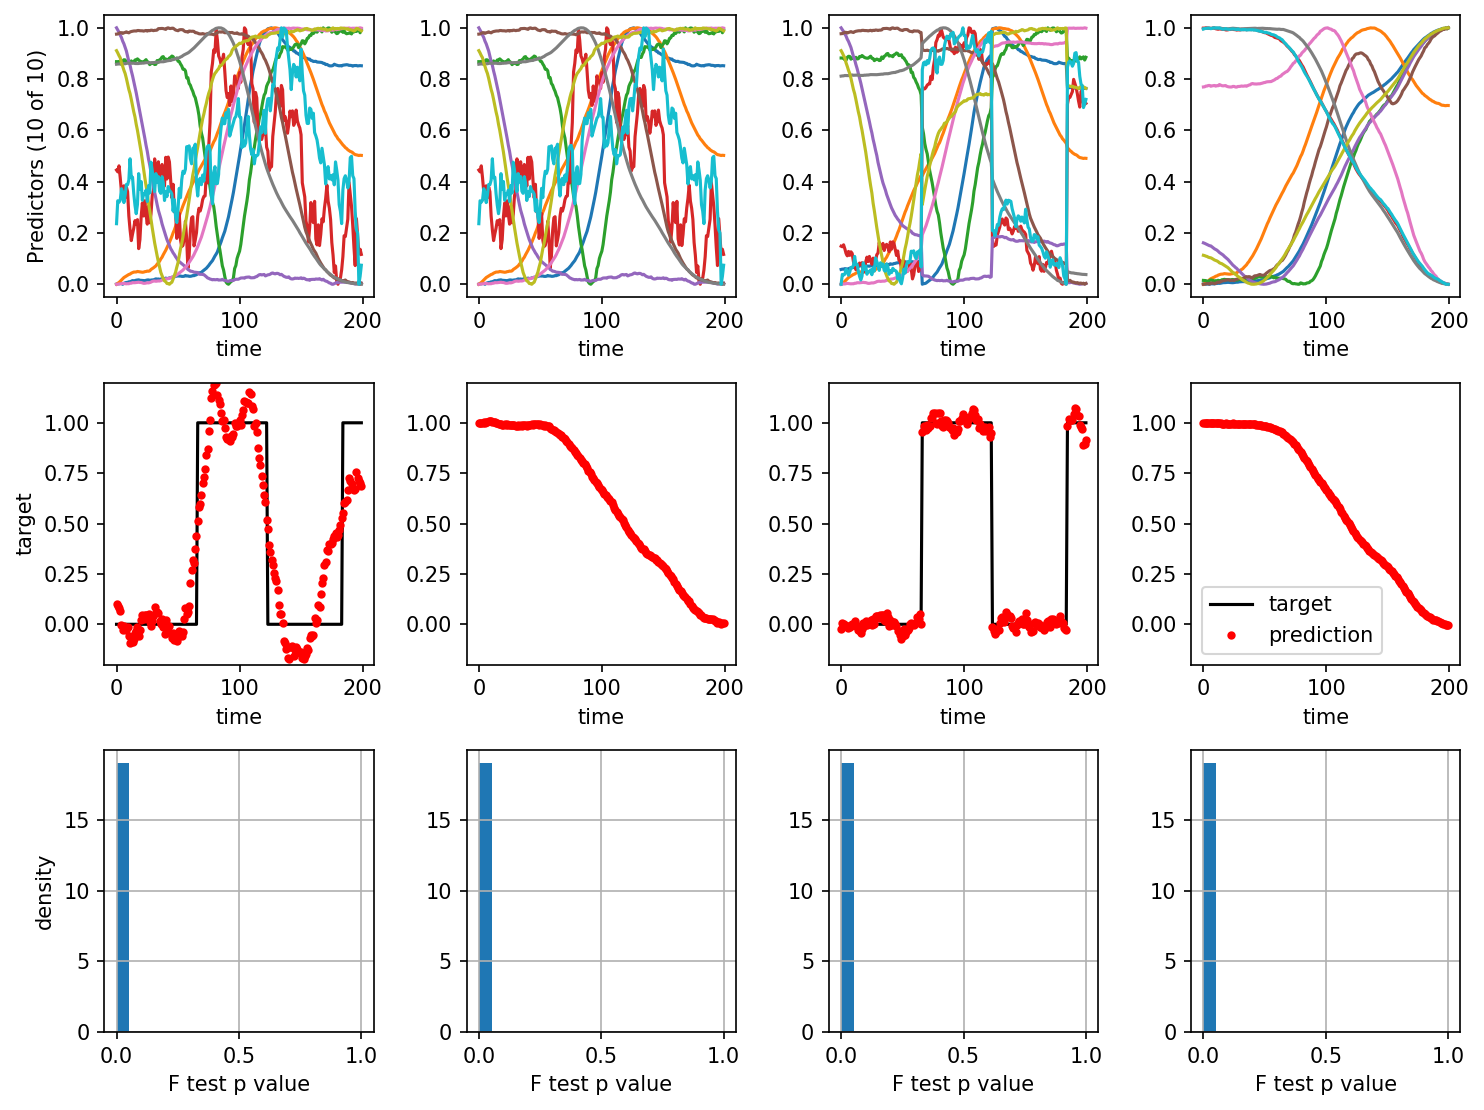

In [8]:
# p values for multiple linear regression

if 1: # make 0 to skip calculations
    p_naive = np.zeros((n_params, R))
    for i in range(n_params):
        for r in range(R):
            x, y = test_data[i][r]
            model = sm.OLS(y,np.hstack((x,np.ones((params.T, 1))))).fit()  # Ordinary Least Squares
            p_naive[i, r] = model.f_pvalue
        
fig, ax = plt.subplots(3, n_params, figsize=(10, 7.5), dpi=150)
for i in range(n_params):
    x, y = test_data[i][0]
    ax[0, i].plot(x[:, :])
    ax[1, i].plot(y, 'k')
    _, _, y_hat = ridge_error(x, y)
    ax[1, i].plot(y_hat, 'r.')
    ax[1, i].set_ylim([-.2, 1.2])
    ax[2, i].hist(p_naive[i], np.linspace(0, 1, 20), density=True)

    ax[2, i].grid()
    ax[0, i].set_xlabel('time')
    ax[1, i].set_xlabel('time')
    ax[2, i].set_xlabel('F test p value')
    
ax[0, 0].set_ylabel(f'Predictors (10 of {params.C})')
ax[1, 0].set_ylabel('target')
ax[2, 0].set_ylabel('density')
ax[1, 3].legend(('target', 'prediction'))

plt.tight_layout()
if SaveFigs: 
    plt.savefig('Ftest.png', dpi=300)

p_value = 0.762
p_value = 0.7979999999999999
p_value = 0.0
p_value = 0.522


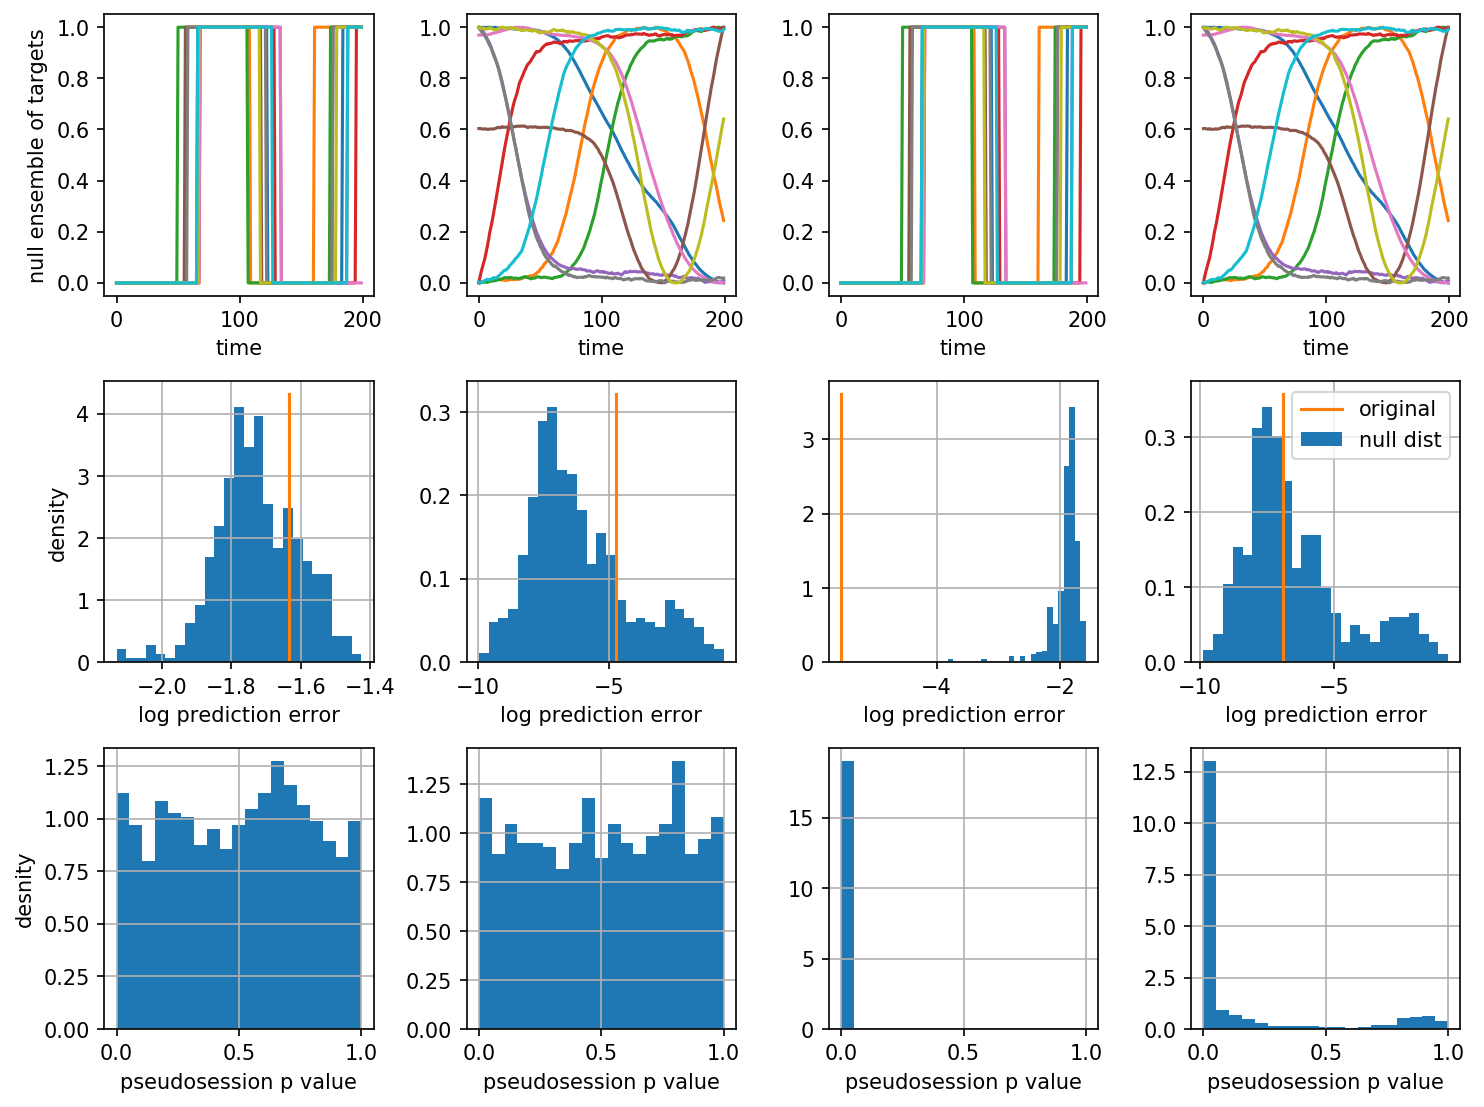

In [9]:
# pseudosession method

if 1: # make 0 to skip calculations
    p_pseudosession = np.zeros((n_params, R))
    pScore_pseud = np.zeros((n_params, N))
    uScore_pseud = np.zeros(n_params)
    for i, params in enumerate(param_list):
        np.random.seed(seed)
        for r in range(R):
            x, y = test_data[i][r]
            uScore_pseud[i], _, _ = ridge_error(x, y) # unpermuted score

            for n in range(N):
                _, y2 = make_data(params)
                pScore_pseud[i, n], _, _ = ridge_error(x, y2)
            # compare the percentile rank of uScore_pseud against the pScore_pseud array
            p_pseudosession[i, r] = stats.percentileofscore(pScore_pseud[i], uScore_pseud[i])/100  

fig, ax = plt.subplots(3, n_params, figsize=(10,7.5), dpi=150)#, sharey='row')
for i, params in enumerate(param_list):
    np.random.seed(seed)
    for n in range(10): 
        _, y2 = make_data(params)
        ax[0, i].plot(y2)
    ax[1, i].hist(np.log(pScore_pseud[i]), 25, density=True)
    ax[1, i].plot(np.full(2, np.log(uScore_pseud[i])), ax[1, i].get_ylim())
    ax[1, i].grid()

    print(f'p_value = {p_pseudosession[i, -1]}')
    ax[2, i].hist(p_pseudosession[i], np.linspace(0,1,20), density=True)
    ax[2, i].grid()
    ax[0, i].set_xlabel('time')
    ax[1, i].set_xlabel('log prediction error')
    ax[2, i].set_xlabel('pseudosession p value')
        
ax[0, 0].set_ylabel('null ensemble of targets')
ax[1, 0].set_ylabel('frequency')
ax[1, 0].set_ylabel('density')
ax[2, 0].set_ylabel('desnity')
ax[1, 3].legend(['original', 'null dist'])
    
plt.tight_layout()
if SaveFigs: plt.savefig('Pseudosession.png', dpi=300)

data set 0
data set 1
data set 2
data set 3


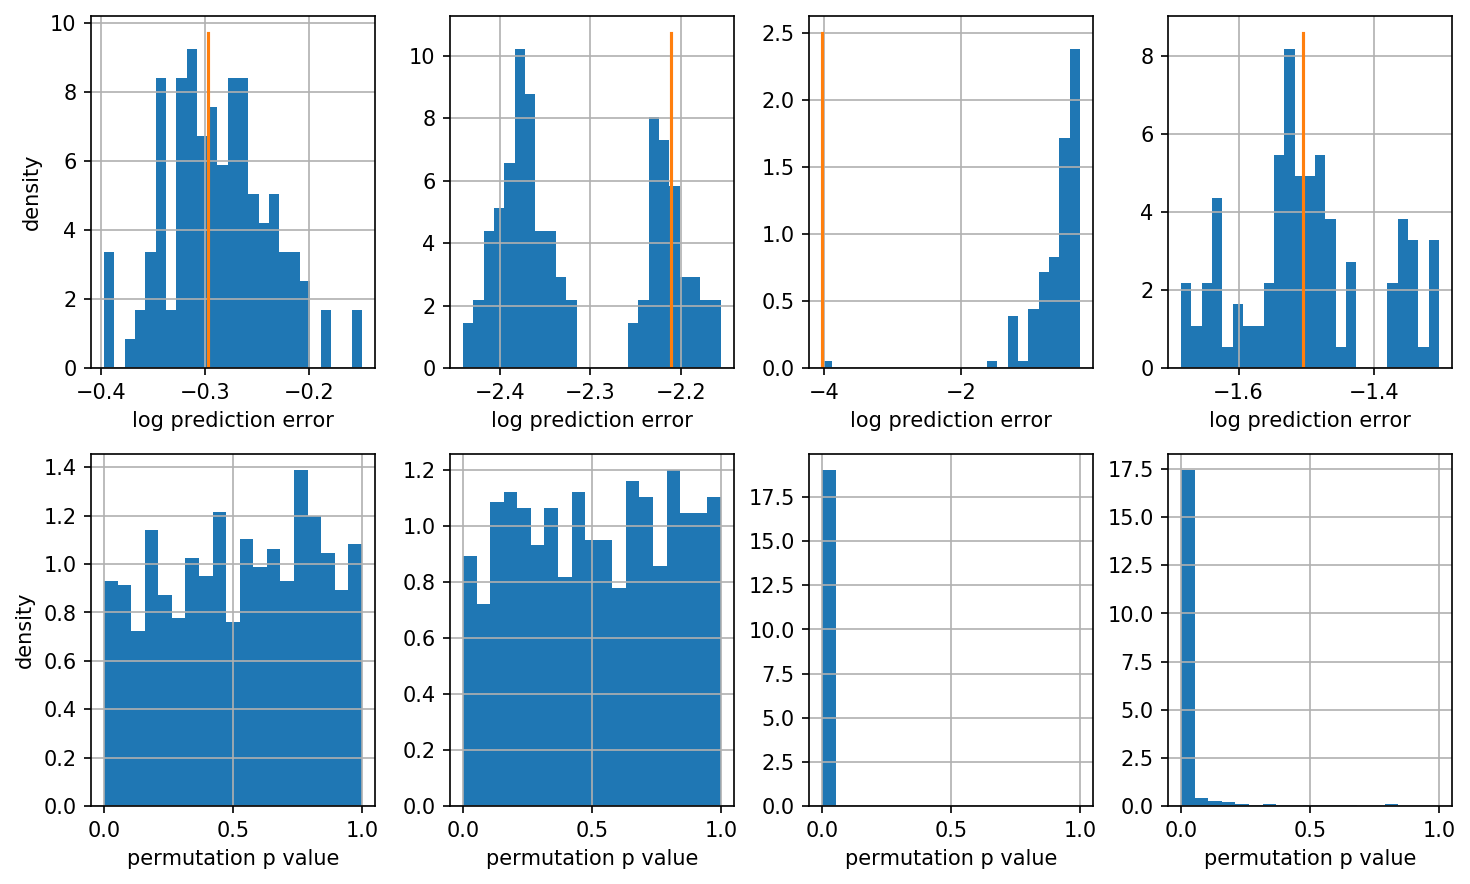

In [10]:
# Session permutation
S = 5 # number of sessions

if 1: # make 0 to skip calculations
    np.random.seed(seed)
        
    p_perm = np.zeros((n_params, R))
    uScore_perm = np.zeros(n_params)
    pScore_perm = np.zeros((n_params, np.math.factorial(S)))

    for i, params in enumerate(param_list):
        print(f'data set {i}')
        for r in range(R):
            x = np.empty(S, dtype=object)
            y = np.empty(S, dtype=object)

            uScore_perm[i] = 0
            for s in range(S):
                x[s], y[s] = make_data(params)
                sc, _, _ = ridge_error(x[s], y[s], 0)
                uScore_perm[i] += sc

            pScore_perm[i] = 0
            for j, p in enumerate(itertools.permutations(range(S))):
                for s in range(S):
                    sc, _, _ = ridge_error(x[s], y[p[s]], 0)
                    pScore_perm[i, j] += sc

            p_perm[i, r] = stats.percentileofscore(pScore_perm[i], uScore_perm[i])/100
        
fig, ax = plt.subplots(2,len(param_list), figsize=(10,6), dpi=150)
for i in range(n_params):
    ax[0, i].hist(np.log(pScore_perm[i]), 25, density=True)
    ax[0, i].plot(np.full(2,np.log(uScore_perm[i])), ax[0,i].get_ylim())
    ax[0, i].grid()
    ax[1, i].hist(p_perm[i],np.linspace(0,1,20), density=True)
    ax[1, i].grid()
    ax[0, i].set_xlabel('log prediction error')
    ax[1, i].set_xlabel('permutation p value')


ax[0, 0].set_ylabel('density')
ax[1, 0].set_ylabel('density')

plt.tight_layout()
if SaveFigs: plt.savefig('SessionPerm.png', dpi=300)

# Simulation

## random walk neurons vs. value from foraging

In [6]:
def gen_random_walk_neuron(n_trial, diff_para=0.1, f_1=2.5, 
                           seed=None, plot=False):
    if seed:
        np.random.seed(seed)

    firing_rate = np.zeros(n_trial)
    firing_rate[0] = np.random.uniform(f_1-0.1, f_1+0.1)
    for i in range(1, n_trial):
        firing_rate[i] = max((0, firing_rate[i-1]+np.random.normal(loc=0, scale=diff_para, size=1)))
    
    if plot:
        plt.plot(firing_rate)

    return firing_rate


def gen_action_value_neuron(qs, k_max_modulation=2.35, f_baseline=2.5, 
                            seed=None, plot=False):
    if seed:
        np.random.seed(seed)
    
    r_neuron_modulation = np.random.uniform(low=-1.0, high=1.0, size=1)
    firing_rate = f_baseline + k_max_modulation * r_neuron_modulation * qs
    spike_cts = np.random.poisson(lam=firing_rate)
    
    if plot:
        plt.plot(spike_cts)

    return spike_cts

In [7]:
subject_id = 482353
model_id = 10
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable 
                    & {'subject_id': subject_id, 
                       'model_id': model_id})

df_Q = pd.DataFrame(q_latent_variable.fetch())
df_Q_left = df_Q[df_Q['water_port']=='left']#.sort_values(by=['trial'])
df_Q_right = df_Q[df_Q['water_port']=='right']#.sort_values(by=['trial'])

# get only Qs columns
df_Q_right = df_Q_right[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_right'})#.reset_index(drop=True)
df_Q_left = df_Q_left[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_left'})#.reset_index(drop=True)
df_Qs = df_Q_left.merge(df_Q_right)

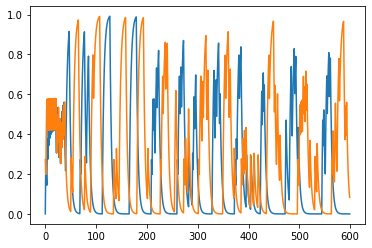

In [51]:
plt.plot(df_Qs[df_Qs['session']==1]['Q_left'].values)
plt.plot(df_Qs[df_Qs['session']==1]['Q_right'].values)

In [5]:
# select sessions
sessions_all = np.unique(df_Qs['session'].values)
print(f'total sessions: {len(sessions_all)}, {sessions_all}')

n_session_to_ana = 5
manual_selection = True
if manual_selection:
    sessions = [38, 39, 40, 42, 45]
else:
    sessions = np.random.choice(sessions_all, size=n_session_to_ana)
print(f'selected sessions for ana: {sessions}')

total sessions: 45, [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
selected sessions for ana: [38, 39, 40, 42, 45]


In [53]:
# generate simulated neurons
n_neurons = 2000
action_neurons = pd.DataFrame(columns=['session', 'neuron_id', 'firing_rates'])
rw_neurons = pd.DataFrame(columns=['session', 'neuron_id', 'firing_rates'])

for session in sessions:
    df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
    X = df_Qs_session[['Q_left', 'Q_right']]
    print(f'session {session}: {X.shape}')

    # action neurons
    for n in range(n_neurons):    
        q_side = random.choice(['Q_left', 'Q_right'])
        fr = gen_action_value_neuron(X[q_side].values)
        action_neurons.loc[len(action_neurons.index)] = [session, n, fr]

    # random walk neurons
    for n in range(n_neurons):
        fr = gen_random_walk_neuron(len(X))
        rw_neurons.loc[len(rw_neurons.index)] = [session, n, fr]

session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)


In [54]:
df_action_neuron_fit = pd.DataFrame(columns=['session', 'neuron_id', 'fit_session', 'tvalues', 'params'])
df_rw_neuron_fit = pd.DataFrame(columns=['session', 'neuron_id', 'fit_session', 'tvalues', 'params'])

# fit simulated neurons
for session in sessions:
    
    df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
    X = df_Qs_session[['Q_left', 'Q_right']]
    X = sm.add_constant(X)
    print(f'session {session}: {X.shape}')

    for n in range(n_neurons):
        # action neurons
        fr = action_neurons[(action_neurons['session']==session) & (action_neurons['neuron_id']==n)]['firing_rates'].values[0]
        model = sm.OLS(fr, X)
        results = model.fit()
        df_action_neuron_fit.loc[len(df_action_neuron_fit.index)] = [session, n, session, results.tvalues, results.params]

    for n in range(n_neurons):
        # random walk neurons
        fr = rw_neurons[(action_neurons['session']==session) & (action_neurons['neuron_id']==n)]['firing_rates'].values[0]
        model = sm.OLS(fr, X)
        results = model.fit()
        df_rw_neuron_fit.loc[len(df_rw_neuron_fit.index)] = [session, n, session, results.tvalues, results.params]

session 38: (468, 3)
session 39: (594, 3)
session 40: (669, 3)
session 42: (1143, 3)
session 45: (635, 3)


check sum of dots: 10000
10000.0
3294
3169
217
97
check sum of dots: 10000
10000.0
2280
2276
1607
520


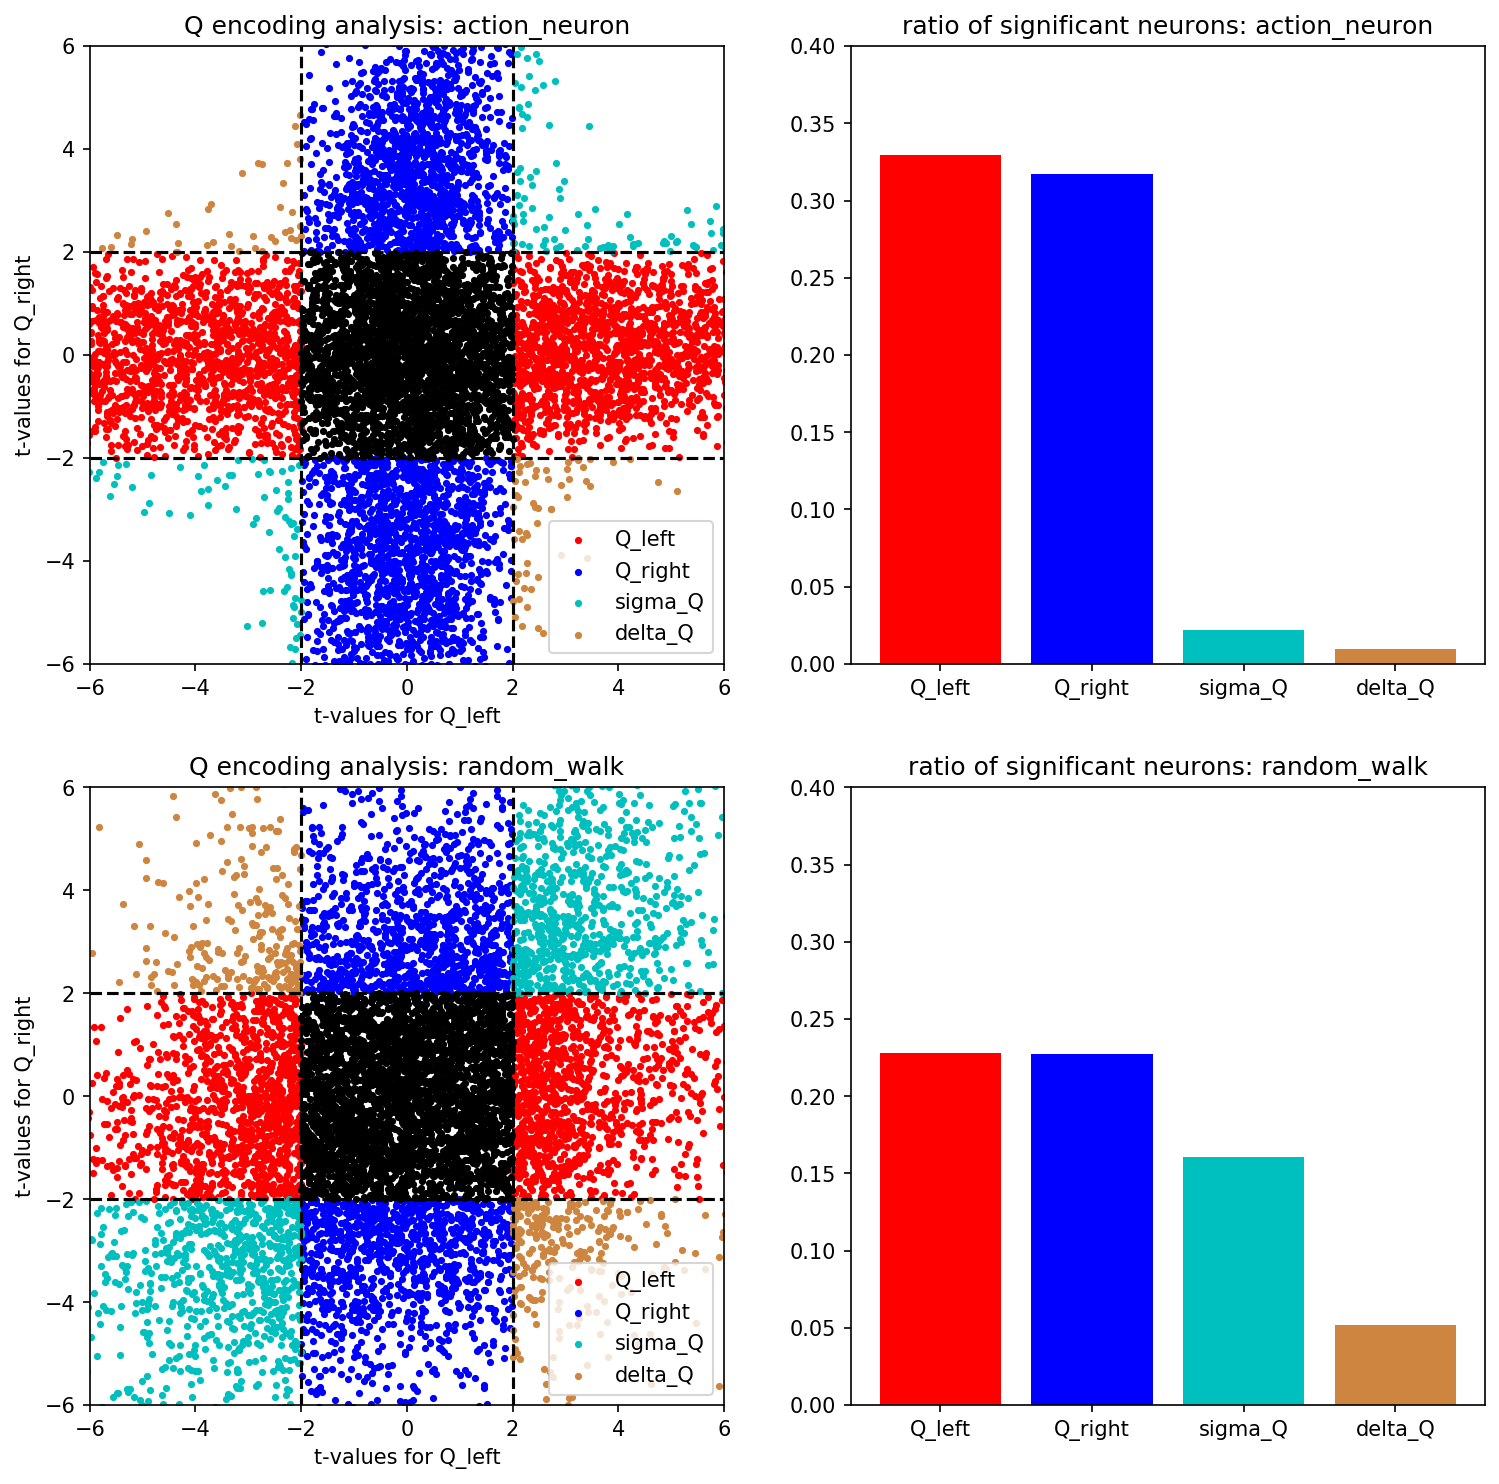

In [55]:
df_t_values_dict = {
    'action_neuron': pd.DataFrame(df_action_neuron_fit['tvalues'].values.tolist(), index=df_action_neuron_fit['tvalues'].index),
    'random_walk': pd.DataFrame(df_rw_neuron_fit['tvalues'].values.tolist(), index=df_rw_neuron_fit['tvalues'].index)
}

colors = ['r', 'b', 'c', 'peru']
dot_size = 6

neuron_types = ['action_neuron', 'random_walk']

fig, axs = plt.subplots(2, 2, figsize=(12, 12), dpi=150)
for i, neuron_type in enumerate(neuron_types):
    df_t_values = df_t_values_dict[neuron_type]

    df_t_Q_left = df_t_values[(abs(df_t_values['Q_left'])>=2) & (abs(df_t_values['Q_right'])<2)]
    axs[i, 0].scatter(df_t_Q_left['Q_left'].values, df_t_Q_left['Q_right'].values, 
                      color='r', s=dot_size, label='Q_left')
    df_t_Q_right = df_t_values[(abs(df_t_values['Q_right'])>=2) & (abs(df_t_values['Q_left'])<2)]
    axs[i, 0].scatter(df_t_Q_right['Q_left'].values, df_t_Q_right['Q_right'].values, 
                      color='b', s=dot_size, label='Q_right')
    df_t_sigma_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']>=2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']<=-2))]
    axs[i, 0].scatter(df_t_sigma_Q['Q_left'].values, df_t_sigma_Q['Q_right'].values, 
                      color='c', s=dot_size, label='sigma_Q')
    df_t_delta_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']<=-2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']>=2))]
    axs[i, 0].scatter(df_t_delta_Q['Q_left'].values, df_t_delta_Q['Q_right'].values, 
                      color='peru', s=dot_size, label='delta_Q')
    df_t_null = df_t_values[(abs(df_t_values['Q_left'])<2) & (abs(df_t_values['Q_right'])<2)]
    axs[i, 0].scatter(df_t_null['Q_left'].values, df_t_null['Q_right'].values, 
                      color='k', s=dot_size)

    print(f'check sum of dots: {len(df_t_Q_left)+len(df_t_Q_right)+len(df_t_sigma_Q)+len(df_t_delta_Q)+len(df_t_null)}')

    axs[i, 0].axhline(-2, color='k', linestyle='--')
    axs[i, 0].axhline(2, color='k', linestyle='--')
    axs[i, 0].axvline(-2, color='k', linestyle='--')
    axs[i, 0].axvline(2, color='k', linestyle='--')

    axs[i, 0].set_title(f'Q encoding analysis: {neuron_type}')
    axs[i, 0].set_xlim(-6, 6)
    axs[i, 0].set_ylim(-6, 6)
    axs[i, 0].set_xlabel('t-values for Q_left')
    axs[i, 0].set_ylabel('t-values for Q_right')
    axs[i, 0].legend()


    names = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
    print(float(len(df_t_values)))
    print(len(df_t_Q_left))
    print(len(df_t_Q_right))
    print(len(df_t_sigma_Q))
    print(len(df_t_delta_Q))
    values = [
        len(df_t_Q_left)/ float(len(df_t_values)),
        len(df_t_Q_right)/ float(len(df_t_values)),
        len(df_t_sigma_Q)/ float(len(df_t_values)),
        len(df_t_delta_Q)/ float(len(df_t_values))
    ]
    axs[i, 1].bar(names, values, color=colors)
    x_lim = axs[i, 1].get_xlim()
    axs[i, 2].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[i, 1].set_title(f'ratio of significant neurons: {neuron_type}')
    axs[i, 1].set_ylim(0, 0.4)


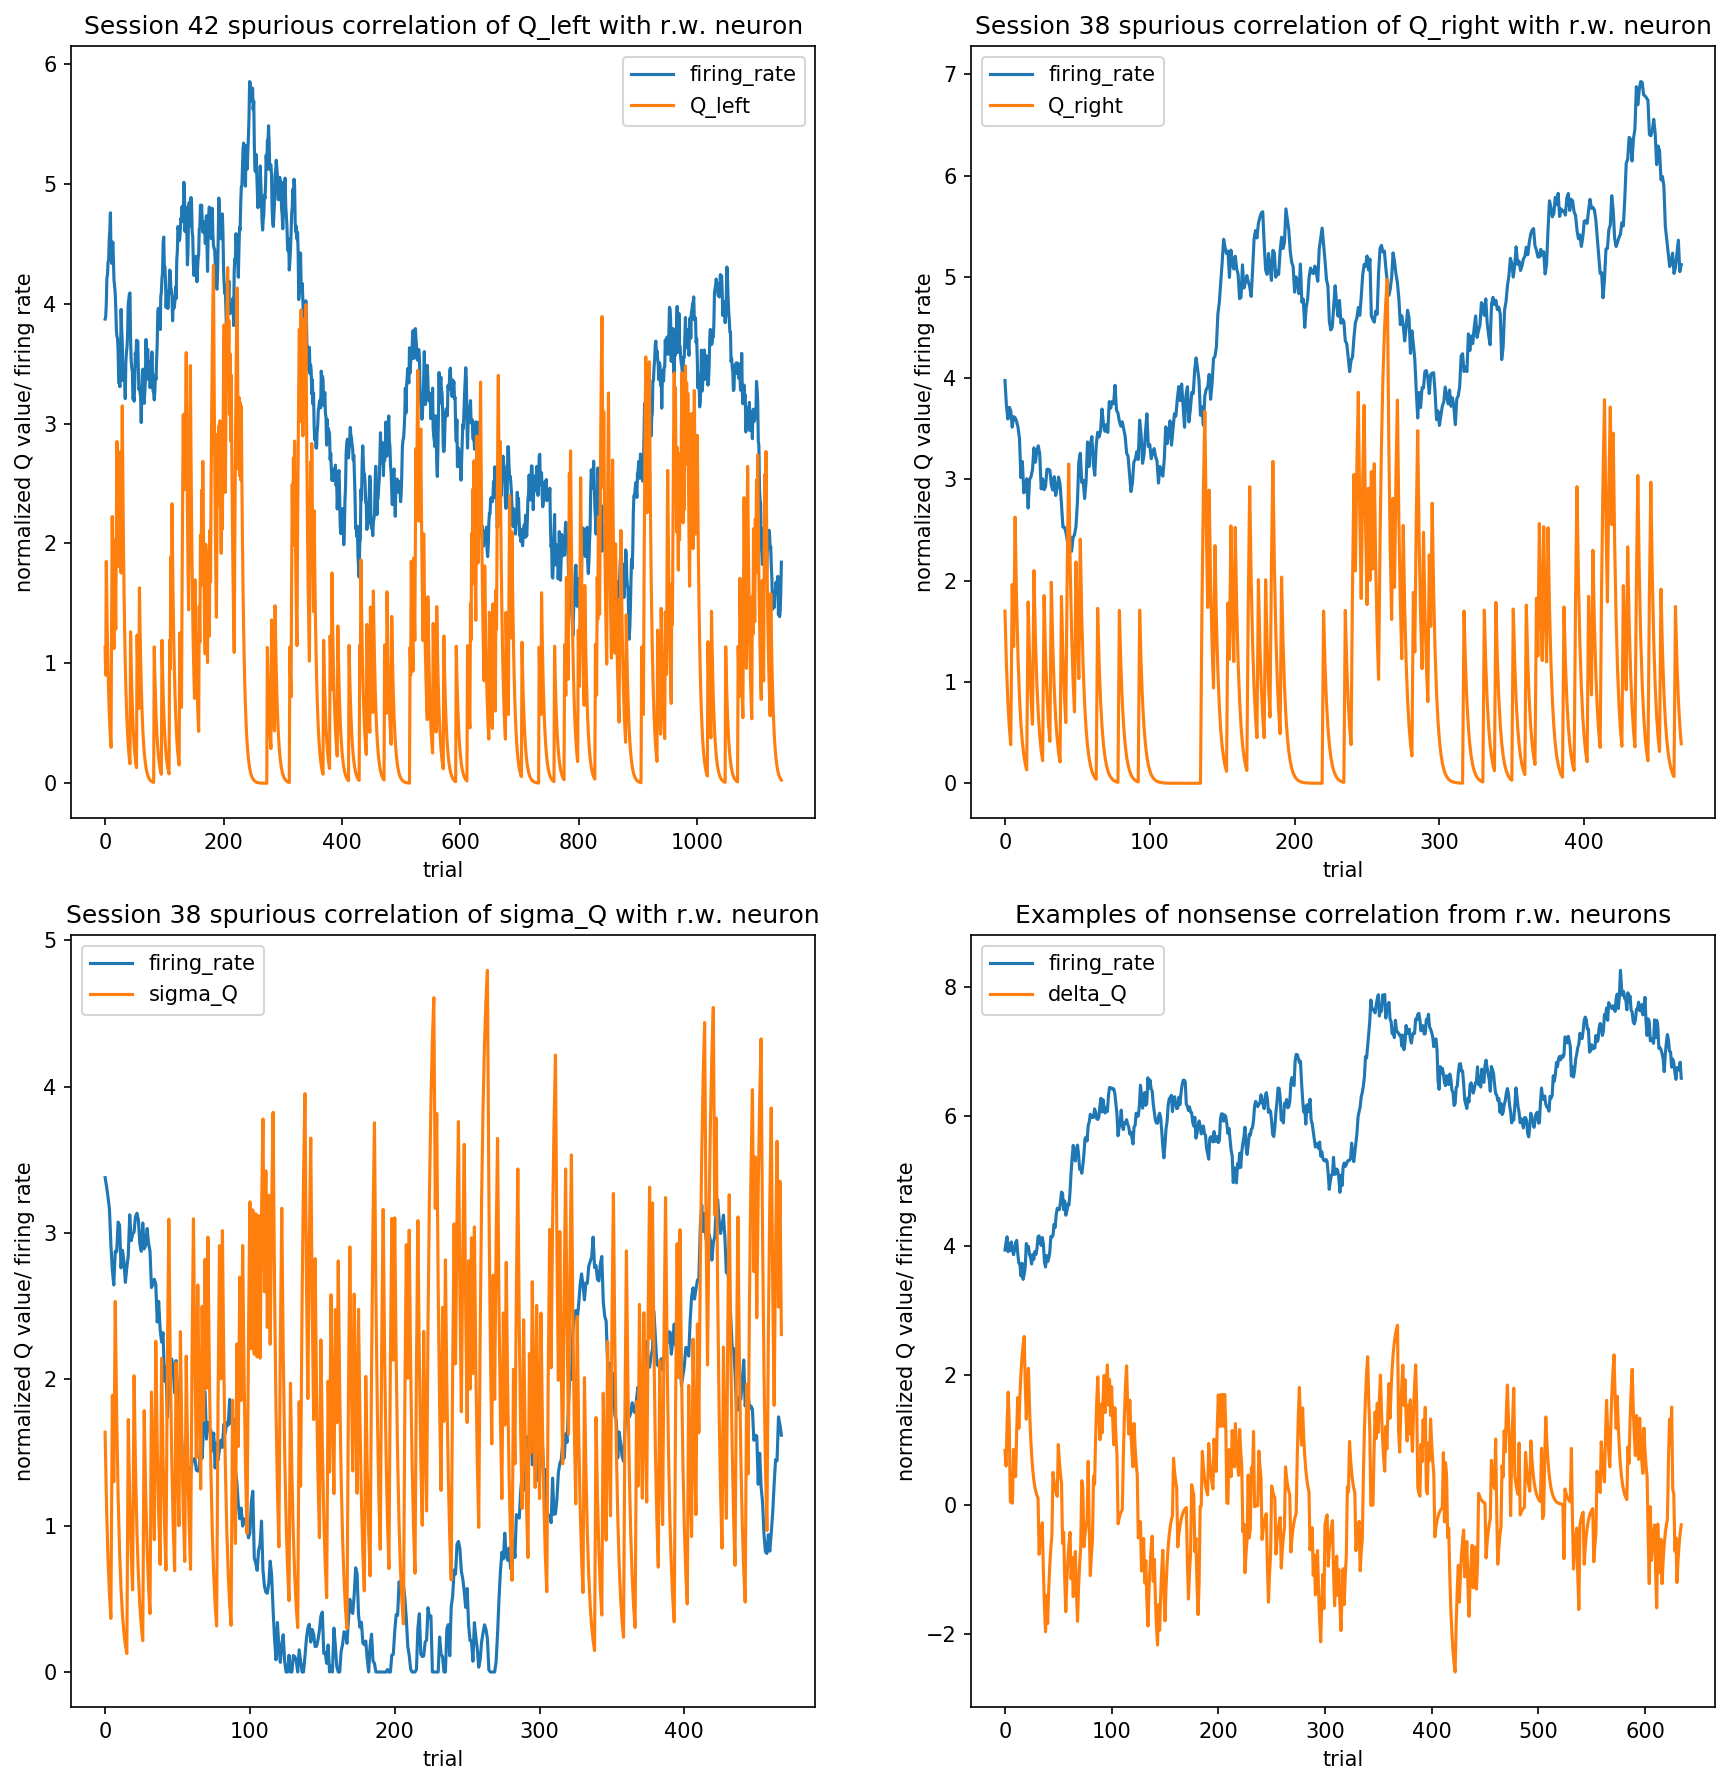

In [57]:
# plot example neurons 
plot_threshold = 3
neuron_type = 'random_walk'
df_t_values = df_t_values_dict[neuron_type]

def ax_plot_normalized_traces(ax, fr, qs, q_type, session):
    '''
    q_type: 'Q_left', 'Q_right', 'sigma_Q', 'delta_Q'
    '''
    fr_normalized = fr/ np.std(fr)
    qs_normalized = qs/ np.std(qs)
    ax.plot(fr_normalized, label='firing_rate')
    ax.plot(qs_normalized, label=q_type)

    ax.set_title(f'Session {session} spurious correlation of {q_type} with r.w. neuron')
    ax.set_xlabel('trial')
    ax.set_ylabel('normalized Q value/ firing rate')
    ax.legend(loc='best')

    return ax


fig, axs = plt.subplots(2, 2, figsize=(12, 12), dpi=150)
# Q_left neuron example
df_t_Q_left = df_t_values[(abs(df_t_values['Q_left'])>=plot_threshold) & (abs(df_t_values['Q_right'])<2)]
Q_left_ind = np.random.choice(df_t_Q_left.index, size=1)[0]
fr = rw_neurons['firing_rates'].values[Q_left_ind]
session = rw_neurons.iloc[Q_left_ind]['session']
qs = df_Qs[df_Qs['session']==session]['Q_left'].values
axs[0, 0] = ax_plot_normalized_traces(axs[0, 0], fr, qs, 'Q_left', session)

# Q_right neuron example
df_t_Q_right = df_t_values[(abs(df_t_values['Q_left'])<2) & (abs(df_t_values['Q_right'])>=plot_threshold)]
Q_right_ind = np.random.choice(df_t_Q_right.index, size=1)[0]
fr = rw_neurons['firing_rates'].values[Q_right_ind]
session = rw_neurons.iloc[Q_right_ind]['session']
qs = df_Qs[df_Qs['session']==session]['Q_right'].values
axs[0, 1] = ax_plot_normalized_traces(axs[0, 1], fr, qs, 'Q_right', session)

# sigma_Q neuron example
df_t_sigma_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']>=2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']<=-2))]
sigma_Q_ind = np.random.choice(df_t_sigma_Q.index, size=1)[0]
fr = rw_neurons['firing_rates'].values[sigma_Q_ind]
session = rw_neurons.iloc[sigma_Q_ind]['session']
qs = df_Qs[df_Qs['session']==session]['Q_left'].values + df_Qs[df_Qs['session']==session]['Q_right'].values
axs[1, 0] = ax_plot_normalized_traces(axs[1, 0], fr, qs, 'sigma_Q', session)

# delta_Q neuron example
df_t_delta_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']<=-2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']>=2))]
delta_Q_ind = np.random.choice(df_t_delta_Q.index, size=1)[0]
fr = rw_neurons['firing_rates'].values[delta_Q_ind]
session = rw_neurons.iloc[delta_Q_ind]['session']
qs = df_Qs[df_Qs['session']==session]['Q_left'].values - df_Qs[df_Qs['session']==session]['Q_right'].values
axs[1, 1] = ax_plot_normalized_traces(axs[1, 1], fr, qs, 'delta_Q', session)

plt.title('Examples of nonsense correlation from r.w. neurons')
plt.tight_layout()

In [59]:
# bootstrp for effect of diffusion parameter
n_neurons = 1000
diff_paras = [0, 0.0001, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2]
diff_para_fit = {}

for diff_para in diff_paras:
    print(f'diffuson parameter: {diff_para}')
    random_walk_fit = {'fr': [], 'params': [], 't_values': []}
    for session in sessions:
        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
        X = df_Qs_session[['Q_left', 'Q_right']]
        X = sm.add_constant(X)
        print(f' session {session}: {X.shape}')

        for n in range(n_neurons):
            # random walk neurons
            fr = gen_random_walk_neuron(len(X), diff_para=diff_para)
            model = sm.OLS(fr, X)
            results = model.fit()
            random_walk_fit['fr'].append(fr)
            random_walk_fit['params'].append(results.params)
            random_walk_fit['t_values'].append(results.tvalues)
        plt.show()
        plt.close()
    diff_para_fit[diff_para] = random_walk_fit

diffuson parameter: 0
 session 38: (468, 3)
 session 39: (594, 3)
 session 40: (669, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.0001
 session 38: (468, 3)
 session 39: (594, 3)
 session 40: (669, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.025
 session 38: (468, 3)
 session 39: (594, 3)
 session 40: (669, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.05
 session 38: (468, 3)
 session 39: (594, 3)
 session 40: (669, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.075
 session 38: (468, 3)
 session 39: (594, 3)
 session 40: (669, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.1
 session 38: (468, 3)
 session 39: (594, 3)
 session 40: (669, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.125
 session 38: (468, 3)
 session 39: (594, 3)
 session 40: (669, 3)
 session 42: (1143, 3)
 session 45: (635, 3)
diffuson parameter: 0.15
 session 38: (468, 3)


In [60]:
ratio_single_significant_values = []
ratio_double_significant_values = []

for diff_para in diff_paras:
    print(f'diff para: {diff_para}')
    df_t_values = pd.DataFrame(diff_para_fit[diff_para]['t_values'])

    df_t_Q_left = df_t_values[(abs(df_t_values['Q_left'])>=2) & (abs(df_t_values['Q_right'])<2)]
    df_t_Q_right = df_t_values[(abs(df_t_values['Q_right'])>=2) & (abs(df_t_values['Q_left'])<2)]
    df_t_sigma_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']>=2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']<=-2))]
    df_t_delta_Q = df_t_values[((df_t_values['Q_left']>=2) & (df_t_values['Q_right']<=-2)) | 
                            ((df_t_values['Q_left']<=-2) & (df_t_values['Q_right']>=2))]
    df_t_null = df_t_values[(abs(df_t_values['Q_left'])<2) & (abs(df_t_values['Q_right'])<2)]

    print(f'check sum of dots: {len(df_t_Q_left)+len(df_t_Q_right)+len(df_t_sigma_Q)+len(df_t_delta_Q)+len(df_t_null)}')

    ratio_single_significant_values.append((len(df_t_Q_left)+len(df_t_Q_right))/ float(len(df_t_values)))
    ratio_double_significant_values.append((len(df_t_sigma_Q)+len(df_t_delta_Q))/ float(len(df_t_values)))

diff para: 0
check sum of dots: 4998
diff para: 0.0001
check sum of dots: 5000
diff para: 0.025
check sum of dots: 5000
diff para: 0.05
check sum of dots: 5000
diff para: 0.075
check sum of dots: 5000
diff para: 0.1
check sum of dots: 5000
diff para: 0.125
check sum of dots: 5000
diff para: 0.15
check sum of dots: 5000
diff para: 0.175
check sum of dots: 5000
diff para: 0.2
check sum of dots: 5000


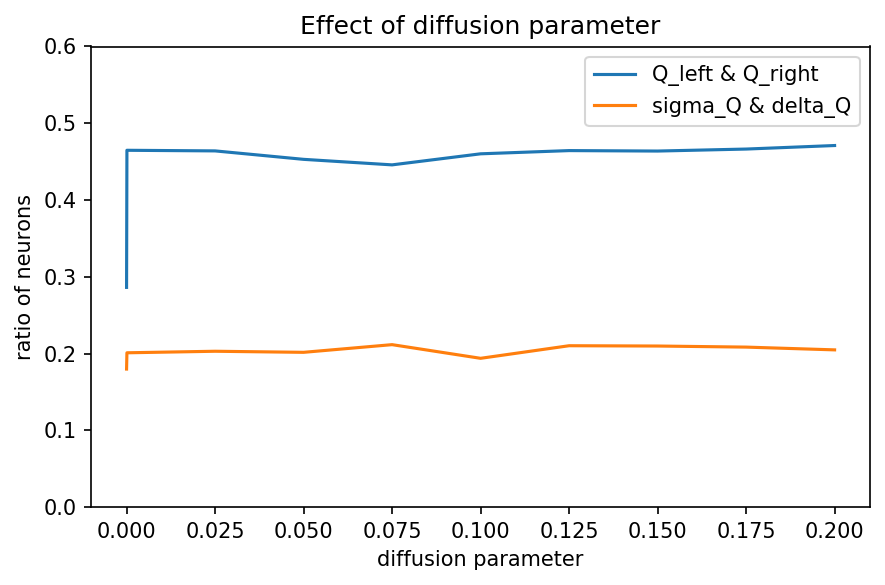

In [61]:
plt.figure(figsize=(6, 4), dpi=150)
plt.plot(diff_paras, ratio_single_significant_values, label='Q_left & Q_right')
plt.plot(diff_paras, ratio_double_significant_values, label='sigma_Q & delta_Q')
plt.title('Effect of diffusion parameter')
plt.ylabel('ratio of neurons')
plt.xlabel('diffusion parameter')
plt.ylim(0, 0.6)
plt.legend()
plt.tight_layout()

## Session permutation

### naive permutation method
- comment: needs lager session numbers

In [62]:

sessions_all = np.unique(df_Qs['session'].values)
print(f'total sessions: {len(sessions_all)}, {sessions_all}')

session_len = []
for sess in sessions_all:
    df_Qs_session = df_Qs[df_Qs['session']==sess].sort_values(by=['trial'])
    session_len.append(len(df_Qs_session))

print(f'min session {session_len.index(min(session_len))} len: {min(session_len)}, max session {session_len.index(max(session_len))} len: {max(session_len)}')

total sessions: 45, [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
min session 34 len: 181, max session 41 len: 1143


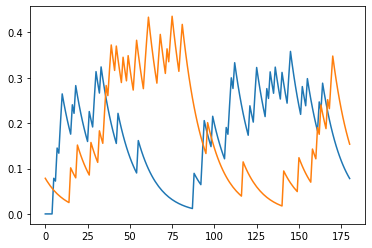

In [63]:
# check the shortest trial
plot_ind = session_len.index(min(session_len))
plt.plot(df_Qs[df_Qs['session']==sessions_all[plot_ind]]['Q_left'].values)
plt.plot(df_Qs[df_Qs['session']==sessions_all[plot_ind]]['Q_right'].values)

In [111]:
# generate simulated neurons
n_neurons = 10
action_neurons = pd.DataFrame(columns=['session', 'neuron_id', 'firing_rates'])
rw_neurons = pd.DataFrame(columns=['session', 'neuron_id', 'firing_rates'])

# use all sessions
sessions = sessions_all
len_min = min(session_len)

for session in sessions:
    df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
    X = df_Qs_session[['Q_left', 'Q_right']]
    print(f'session {session}: {X.shape}')

    # chop the session to chunks of min len
    for i in range(int(np.floor(len(df_Qs_session)/ len_min))):
        t_start = i * len_min

        if i == 0: # remove this to treat different chunks as different sessions
            # action neurons
            for n in range(n_neurons):    
                q_side = random.choice(['Q_left', 'Q_right'])
                fr = gen_action_value_neuron(X[q_side].values[t_start: t_start+len_min])
                action_neurons.loc[len(action_neurons.index)] = [session, n, fr]
            
            # random walk neurons
            for n in range(n_neurons):
               fr = gen_random_walk_neuron(len_min)
               rw_neurons.loc[len(rw_neurons.index)] = [session, n, fr]

session 1: (600, 2)
session 2: (411, 2)
session 3: (512, 2)
session 4: (620, 2)
session 5: (1056, 2)
session 6: (787, 2)
session 7: (936, 2)
session 8: (728, 2)
session 9: (804, 2)
session 10: (703, 2)
session 11: (798, 2)
session 12: (786, 2)
session 13: (791, 2)
session 14: (812, 2)
session 15: (725, 2)
session 16: (840, 2)
session 17: (743, 2)
session 18: (407, 2)
session 19: (639, 2)
session 20: (707, 2)
session 21: (660, 2)
session 22: (722, 2)
session 23: (696, 2)
session 24: (484, 2)
session 25: (606, 2)
session 26: (824, 2)
session 27: (520, 2)
session 28: (751, 2)
session 29: (811, 2)
session 30: (650, 2)
session 31: (581, 2)
session 32: (574, 2)
session 33: (586, 2)
session 34: (379, 2)
session 35: (181, 2)
session 36: (450, 2)
session 37: (321, 2)
session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 41: (891, 2)
session 42: (1143, 2)
session 43: (792, 2)
session 44: (249, 2)
session 45: (635, 2)


In [128]:
# compute the t-values of the regression coefficients 
# of the spike counts on each of the estimated action-values 
# in all possible sessions

df_action_neuron_fit = pd.DataFrame(columns=['session', 'neuron_id', 'fit_session', 'tvalues', 'params'])
df_rw_neuron_fit = pd.DataFrame(columns=['session', 'neuron_id', 'fit_session', 'tvalues', 'params'])

# fit simulated neurons
for fit_session in sessions:
    
    df_Qs_session = df_Qs[df_Qs['session']==fit_session].sort_values(by=['trial'])
    X_fit = df_Qs_session[['Q_left', 'Q_right']]
    X_fit = sm.add_constant(X_fit)
    X_fit = X_fit[:len_min]
    print(f'session {fit_session}: {X_fit.shape}')

    for n in range(n_neurons):
        for gen_session in sessions:
            # action neurons
            fr = action_neurons[(action_neurons['session']==gen_session) & (action_neurons['neuron_id']==n)]['firing_rates'].values[0]
            model = sm.OLS(fr, X_fit)
            results = model.fit()
            df_action_neuron_fit.loc[len(df_action_neuron_fit.index)] = [gen_session, n, fit_session, results.tvalues, results.params]

            # random walk neurons
            fr = rw_neurons[(rw_neurons['session']==gen_session) & (rw_neurons['neuron_id']==n)]['firing_rates'].values[0]
            model = sm.OLS(fr, X_fit)
            results = model.fit()
            df_rw_neuron_fit.loc[len(df_rw_neuron_fit.index)] = [gen_session, n, fit_session, results.tvalues, results.params]

session 1: (181, 3)
session 2: (181, 3)
session 3: (181, 3)
session 4: (181, 3)
session 5: (181, 3)
session 6: (181, 3)
session 7: (181, 3)
session 8: (181, 3)
session 9: (181, 3)
session 10: (181, 3)
session 11: (181, 3)
session 12: (181, 3)
session 13: (181, 3)
session 14: (181, 3)
session 15: (181, 3)
session 16: (181, 3)
session 17: (181, 3)
session 18: (181, 3)
session 19: (181, 3)
session 20: (181, 3)
session 21: (181, 3)
session 22: (181, 3)
session 23: (181, 3)
session 24: (181, 3)
session 25: (181, 3)
session 26: (181, 3)
session 27: (181, 3)
session 28: (181, 3)
session 29: (181, 3)
session 30: (181, 3)
session 31: (181, 3)
session 32: (181, 3)
session 33: (181, 3)
session 34: (181, 3)
session 35: (181, 3)
session 36: (181, 3)
session 37: (181, 3)
session 38: (181, 3)
session 39: (181, 3)
session 40: (181, 3)
session 41: (181, 3)
session 42: (181, 3)
session 43: (181, 3)
session 44: (181, 3)
session 45: (181, 3)


left percentile: [-1.99604204  2.26022251]
right percentile: [-1.39260371  1.60166697]
left percentile: [-6.38949012  4.80122044]
right percentile: [-4.4193147   4.75258586]


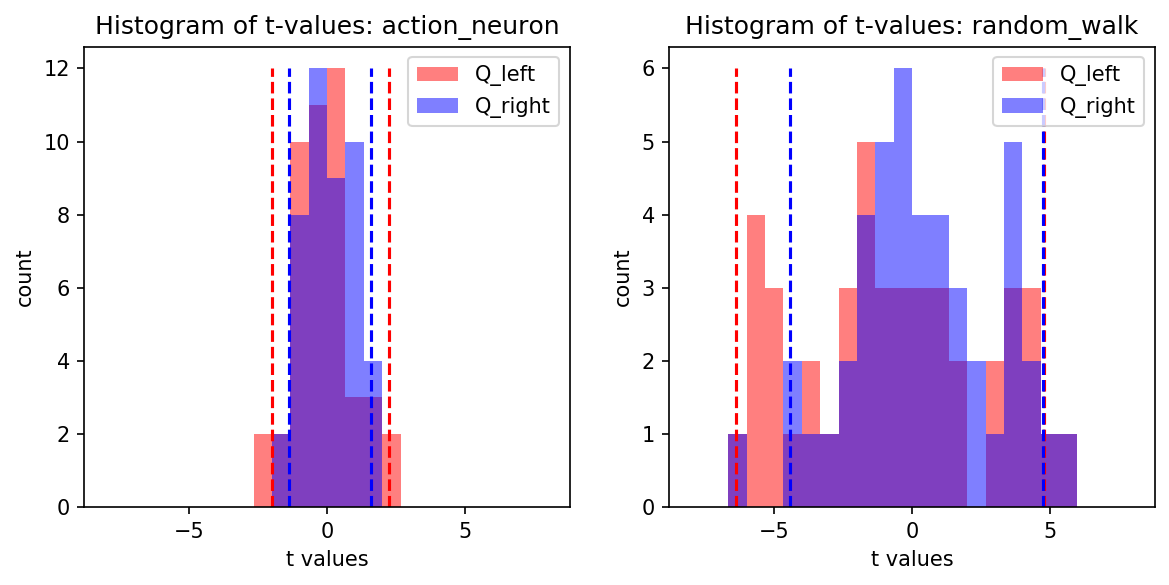

In [186]:
# get the 5% significance boundaries
session = 38
neuron_id = 3
#df_fit_session_neuron = df_action_neuron_fit[(df_action_neuron_fit['session']==session) & (df_action_neuron_fit['neuron_id']==neuron_id)]
#self_id = df_fit_session_neuron[df_fit_session_neuron['fit_session']==session].index[0]

'''
df_fit_session_neuron = df_action_neuron_fit
df_multisession_tvalue_session_neuron = pd.DataFrame(df_fit_session_neuron['tvalues'].values.tolist(), index=df_fit_session_neuron['tvalues'].index)
qs = df_multisession_tvalue_session_neuron['Q_right'].values
percentiles_2_compute = [5, 95]
q_percentiles = np.percentile(qs, percentiles_2_compute)
hist, bin, _ = plt.hist(qs, bins=32, range=(-4,4))
plt.vlines(q_percentiles, 0, np.max(hist))


df_fit_session_neuron = df_rw_neuron_fit[(df_rw_neuron_fit['session']==session) & (df_rw_neuron_fit['neuron_id']==neuron_id)]
#df_fit_session_neuron = df_rw_neuron_fit
df_multisession_tvalue_session_neuron = pd.DataFrame(df_fit_session_neuron['tvalues'].values.tolist(), index=df_fit_session_neuron['tvalues'].index)
qs = df_multisession_tvalue_session_neuron['Q_right'].values
percentiles_2_compute = [2.5, 97.5]
q_percentiles = np.percentile(qs, percentiles_2_compute)
hist, bin, _ = plt.hist(qs, bins=32, range=(-8,8))
plt.vlines(q_percentiles, 0, np.max(hist))
'''

plot_lim = (-8, 8)

df_fit_dict = {
    'action_neuron': df_action_neuron_fit,
    'random_walk': df_rw_neuron_fit
}

neuron_types = ['action_neuron', 'random_walk']

fig, axs = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
for i, neuron_type in enumerate(neuron_types):
    df_fit_session_neuron = df_fit_dict[neuron_type]
    # select the specified session
    df_fit_session_neuron = df_fit_session_neuron[(df_fit_session_neuron['session']==session) & (df_fit_session_neuron['neuron_id']==neuron_id)]
    df_t_values = pd.DataFrame(df_fit_session_neuron['tvalues'].values.tolist(), index=df_fit_session_neuron['tvalues'].index)
    
    # calculating percentiles
    t_left = df_t_values['Q_left'].values
    t_right = df_t_values['Q_right'].values
    percentiles_2_compute = [2.5, 97.5]
    t_left_percentile = np.percentile(t_left, percentiles_2_compute)
    t_right_percentile = np.percentile(t_right, percentiles_2_compute)
    print(f'left percentile: {t_left_percentile}')
    print(f'right percentile: {t_right_percentile}')
    
    plot_xlim = (np.floor(t_left_percentile[0]), np.floor(t_left_percentile[1])+1)
    plot_ylim = (np.floor(t_right_percentile[0]), np.floor(t_right_percentile[1])+1)
    hist_left, _, _ = axs[i].hist(t_left, bins=24, range=plot_lim, histtype='stepfilled', 
                                  color='r', label='Q_left', alpha=0.5)
    hist_right, _, _ = axs[i].hist(t_right, bins=24, range=plot_lim, histtype='stepfilled', 
                                   color='b', label='Q_right', alpha=0.5)
    axs[i].set_title(f'Histogram of t-values: {neuron_type}')
    axs[i].set_xlabel('t values')
    axs[i].set_ylabel('count')
    top = np.max(np.concatenate((hist_left, hist_right), axis=0))
    axs[i].vlines(t_left_percentile, 0, top, color='r', linestyle='--')
    axs[i].vlines(t_right_percentile, 0, top, color='b', linestyle='--')
    axs[i].legend(loc='best')
plt.tight_layout()

left percentile: [-2.10942405  2.11286758]
right percentile: [-2.07205918  2.09223766]
check sum of dots: 450
450.0
87
73
5
2
left percentile: [-6.43846303  6.45171904]
right percentile: [-5.71501679  5.82301667]
check sum of dots: 450
450.0
27
21
1
1


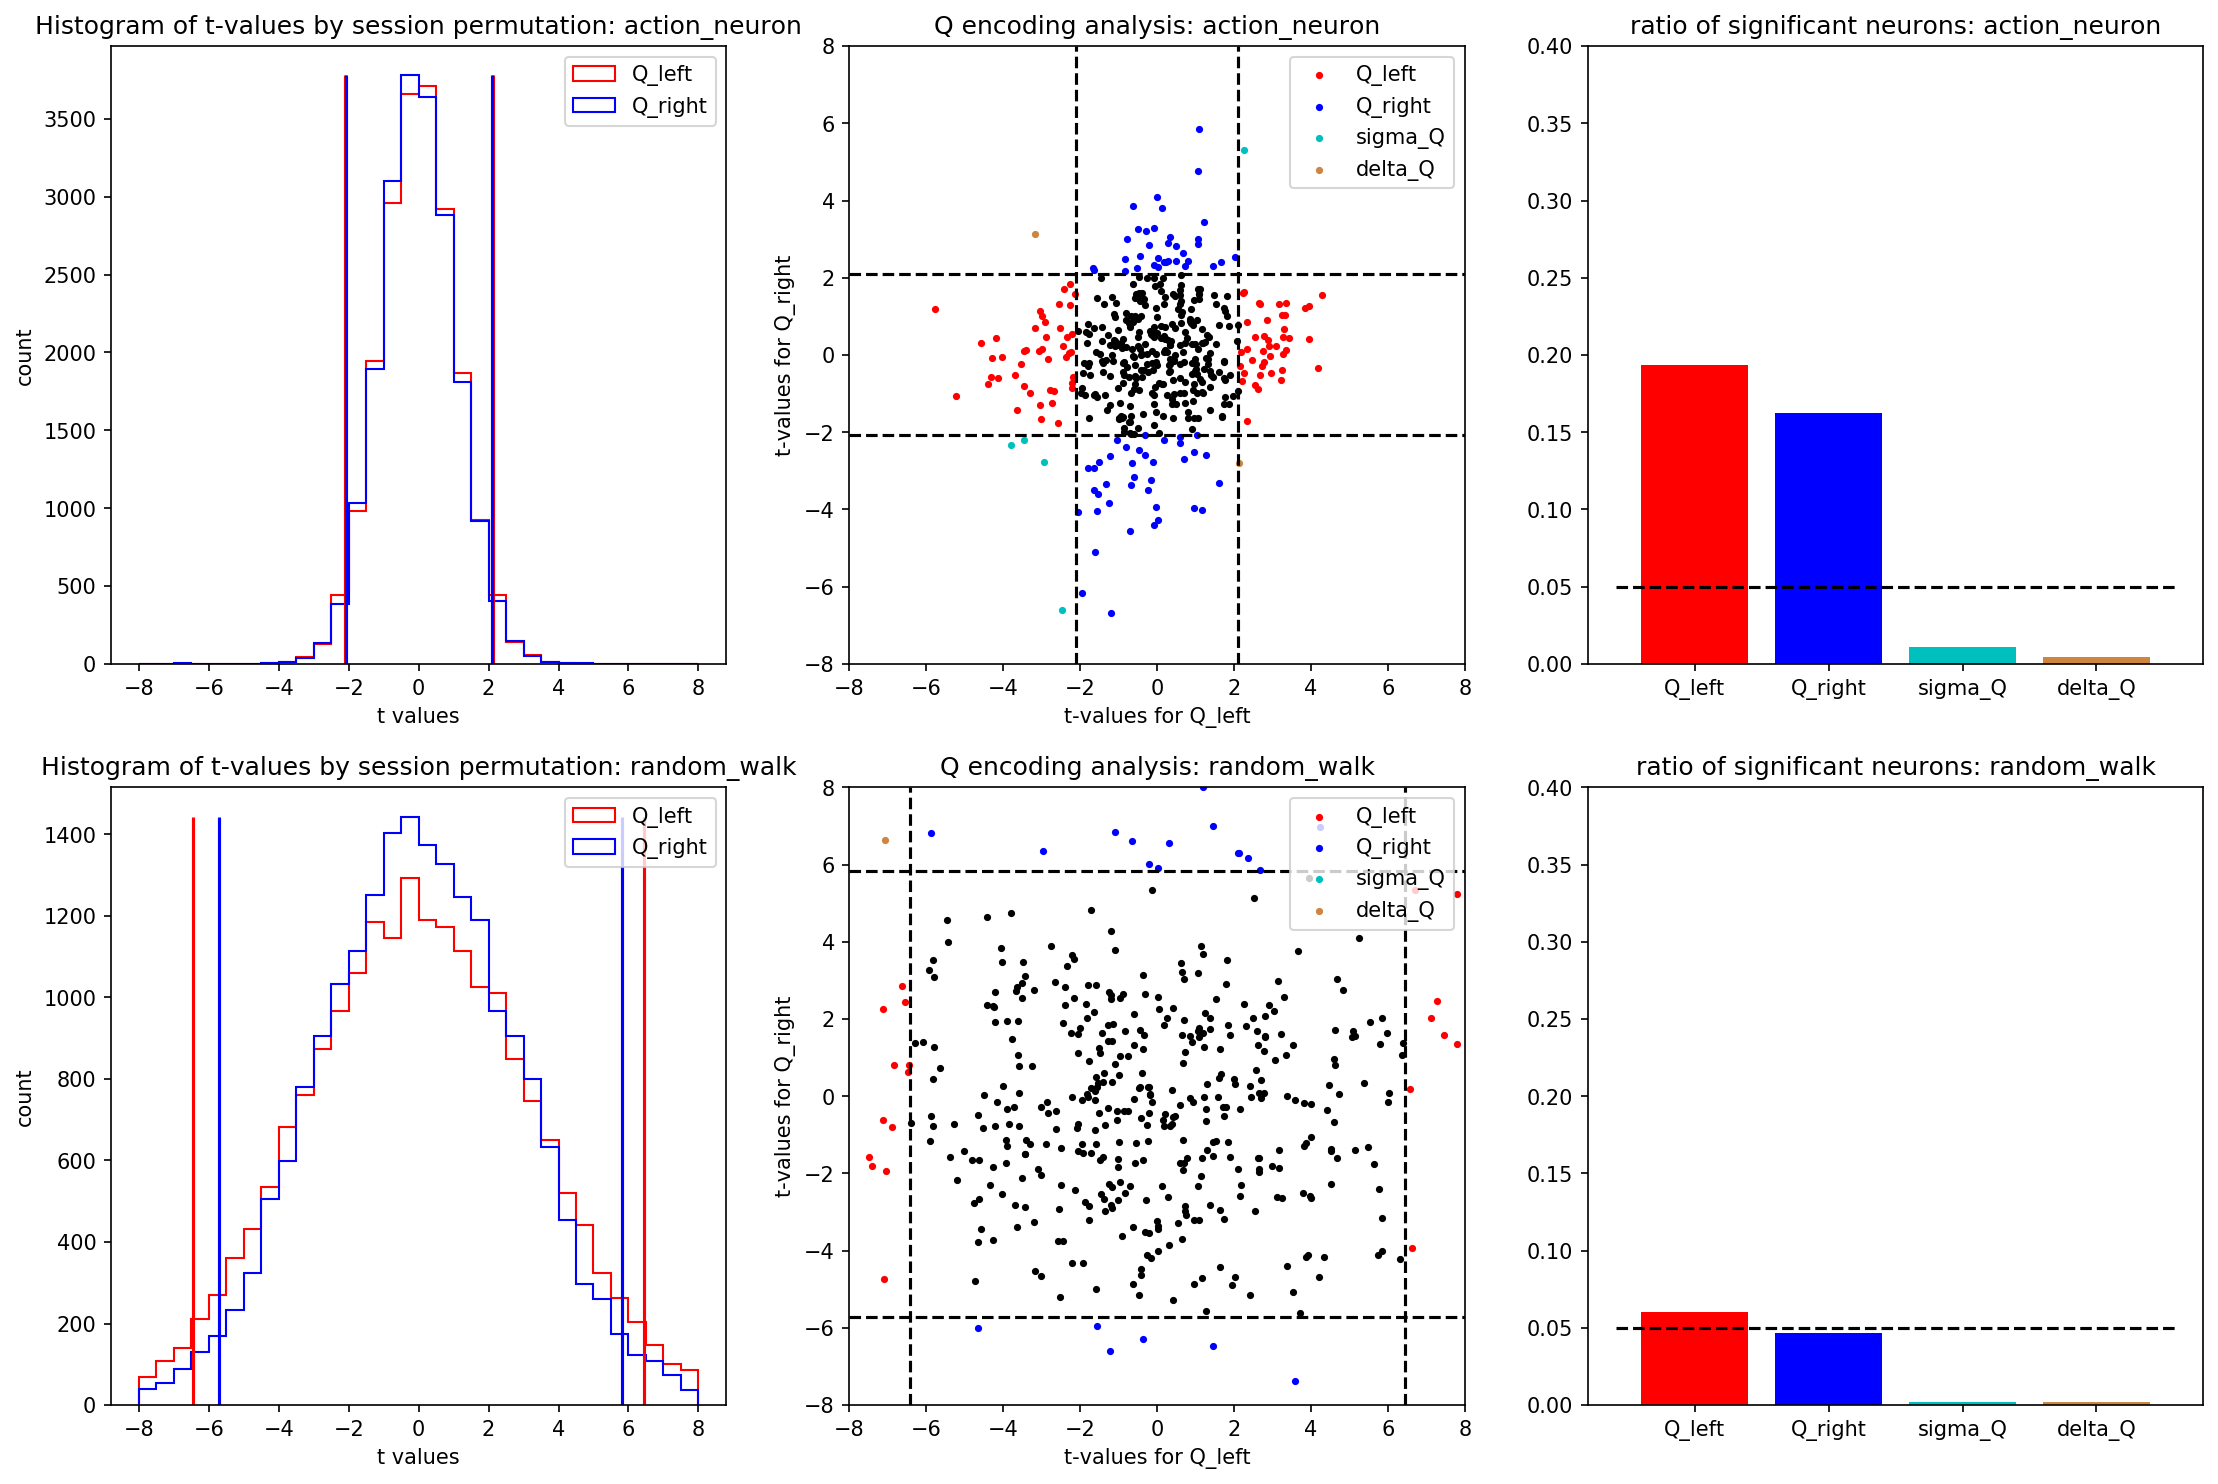

In [170]:
df_t_values_dict = {
    'action_neuron': pd.DataFrame(df_action_neuron_fit['tvalues'].values.tolist(), index=df_action_neuron_fit['tvalues'].index),
    'random_walk': pd.DataFrame(df_rw_neuron_fit['tvalues'].values.tolist(), index=df_rw_neuron_fit['tvalues'].index)
}

df_fit_dict = {
    'action_neuron': df_action_neuron_fit,
    'random_walk': df_rw_neuron_fit
}

colors = ['r', 'b', 'c', 'peru']
dot_size = 6
plot_lim = (-8, 8)

neuron_types = ['action_neuron', 'random_walk']

fig, axs = plt.subplots(2, 3, figsize=(18, 12), dpi=150)
for i, neuron_type in enumerate(neuron_types):
    df_t_values = df_t_values_dict[neuron_type]

    # calculating percentiles
    t_left = df_t_values['Q_left'].values
    t_right = df_t_values['Q_right'].values
    percentiles_2_compute = [2.5, 97.5]
    t_left_percentile = np.percentile(t_left, percentiles_2_compute)
    t_right_percentile = np.percentile(t_right, percentiles_2_compute)
    print(f'left percentile: {t_left_percentile}')
    print(f'right percentile: {t_right_percentile}')
    
    plot_xlim = (np.floor(t_left_percentile[0]), np.floor(t_left_percentile[1])+1)
    plot_ylim = (np.floor(t_right_percentile[0]), np.floor(t_right_percentile[1])+1)

    hist_left, _, _ = axs[i, 0].hist(t_left, bins=32, range=plot_lim, histtype='step', color='r', label='Q_left')
    hist_right, _, _ = axs[i, 0].hist(t_right, bins=32, range=plot_lim, histtype='step', color='b', label='Q_right')
    axs[i, 0].set_title(f'Histogram of t-values by session permutation: {neuron_type}')
    axs[i, 0].set_xlabel('t values')
    axs[i, 0].set_ylabel('count')
    top = np.max(np.concatenate((hist_left, hist_right), axis=0))
    axs[i, 0].vlines(t_left_percentile, 0, top, color='r')
    axs[i, 0].vlines(t_right_percentile, 0, top, color='b')
    axs[i, 0].legend(loc='best')

    # plot only self-fitted session
    df_fit = df_fit_dict[neuron_type]
    self_id = df_fit[df_fit['fit_session']==df_fit['session']].index
    df_t_values = df_t_values.iloc[self_id]

    # plotting
    df_t_Q_left = df_t_values[((df_t_values['Q_left']>=t_left_percentile[1]) | (df_t_values['Q_left']<=t_left_percentile[0])) & 
                              (df_t_values['Q_right']<t_right_percentile[1]) & (df_t_values['Q_right']>t_right_percentile[0])]
    axs[i, 1].scatter(df_t_Q_left['Q_left'].values, df_t_Q_left['Q_right'].values, 
                      color='r', s=dot_size, label='Q_left')
    df_t_Q_right = df_t_values[((df_t_values['Q_right']>=t_right_percentile[1]) | (df_t_values['Q_right']<=t_right_percentile[0])) & 
                              (df_t_values['Q_left']<t_left_percentile[1]) & (df_t_values['Q_left']>t_left_percentile[0])]
    axs[i, 1].scatter(df_t_Q_right['Q_left'].values, df_t_Q_right['Q_right'].values, 
                      color='b', s=dot_size, label='Q_right')
    df_t_sigma_Q = df_t_values[((df_t_values['Q_left']>=t_left_percentile[1]) & (df_t_values['Q_right']>=t_right_percentile[1])) | 
                            ((df_t_values['Q_left']<t_left_percentile[0]) & (df_t_values['Q_right']<t_right_percentile[0]))]
    axs[i, 1].scatter(df_t_sigma_Q['Q_left'].values, df_t_sigma_Q['Q_right'].values, 
                      color='c', s=dot_size, label='sigma_Q')
    df_t_delta_Q = df_t_values[((df_t_values['Q_left']>=t_left_percentile[1]) & (df_t_values['Q_right']<t_right_percentile[0])) | 
                            ((df_t_values['Q_left']<t_left_percentile[0]) & (df_t_values['Q_right']>=t_right_percentile[1]))]
    axs[i, 1].scatter(df_t_delta_Q['Q_left'].values, df_t_delta_Q['Q_right'].values, 
                      color='peru', s=dot_size, label='delta_Q')
    df_t_null = df_t_values[(df_t_values['Q_left']<t_left_percentile[1]) & (df_t_values['Q_left']>=t_left_percentile[0]) & 
                              (df_t_values['Q_right']<t_right_percentile[1]) & (df_t_values['Q_right']>=t_right_percentile[0])]
    axs[i, 1].scatter(df_t_null['Q_left'].values, df_t_null['Q_right'].values, 
                      color='k', s=dot_size)

    print(f'check sum of dots: {len(df_t_Q_left)+len(df_t_Q_right)+len(df_t_sigma_Q)+len(df_t_delta_Q)+len(df_t_null)}')

    axs[i, 1].hlines(t_right_percentile, plot_lim[0], plot_lim[1], color='k', linestyle='--')
    axs[i, 1].vlines(t_left_percentile, plot_lim[0], plot_lim[1], color='k', linestyle='--')
    

    axs[i, 1].set_title(f'Q encoding analysis: {neuron_type}')
    axs[i, 1].set_xlim(plot_lim[0], plot_lim[1])
    axs[i, 1].set_ylim(plot_lim[0], plot_lim[1])
    axs[i, 1].set_xlabel('t-values for Q_left')
    axs[i, 1].set_ylabel('t-values for Q_right')
    axs[i, 1].legend()


    names = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
    print(float(len(df_t_values)))
    print(len(df_t_Q_left))
    print(len(df_t_Q_right))
    print(len(df_t_sigma_Q))
    print(len(df_t_delta_Q))
    values = [
        len(df_t_Q_left)/ float(len(df_t_values)),
        len(df_t_Q_right)/ float(len(df_t_values)),
        len(df_t_sigma_Q)/ float(len(df_t_values)),
        len(df_t_delta_Q)/ float(len(df_t_values))
    ]
    axs[i, 2].bar(names, values, color=colors)
    x_lim = axs[i, 2].get_xlim()
    axs[i, 2].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[i, 2].set_title(f'ratio of significant neurons: {neuron_type}')
    axs[i, 2].set_ylim(0, 0.4)


### Multi-session permutation method

In [5]:
# select sessions
sessions_all = np.unique(df_Qs['session'].values)
print(f'total sessions: {len(sessions_all)}, {sessions_all}')

n_session_to_ana = 5
manual_selection = True
if manual_selection:
    sessions = [38, 39, 40, 42, 45]
else:
    sessions = np.random.choice(sessions_all, size=n_session_to_ana)
print(f'selected sessions for ana: {sessions}')

# get min session length
session_len = []
for session in sessions:
    df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
    session_len.append(len(df_Qs_session))

print(f'min session {session_len.index(min(session_len))} len: {min(session_len)}, max session {session_len.index(max(session_len))} len: {max(session_len)}')
len_min = min(session_len)

total sessions: 45, [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45]
selected sessions for ana: [38, 39, 40, 42, 45]
min session 0 len: 468, max session 3 len: 1143


In [6]:
# generate simulated neurons
n_neurons = 5
neuron_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q', 'rw']

sim_neuron_columns = ['session', 'neuron_id', 'firing_rates']
sim_neurons = {neuron_type: pd.DataFrame(columns=sim_neuron_columns) for neuron_type in neuron_types}

for n in range(n_neurons):

    for gen_session in sessions:
        df_Qs_session = df_Qs[df_Qs['session']==gen_session].sort_values(by=['trial'])
        X = df_Qs_session[['Q_left', 'Q_right']]
        print(f'session {gen_session}: {X.shape}')

        # chop the session to chunks of min len
        for i in range(int(np.floor(len(df_Qs_session)/ len_min))):
            t_start = i * len_min

            if i == 0: # remove this to treat different chunks as different sessions
                for neuron_type in neuron_types:
                    if neuron_type in ['Q_left', 'Q_right']:
                        fr = gen_action_value_neuron(X[neuron_type].values)
                    elif neuron_type == 'sigma_Q':
                        fr = gen_action_value_neuron(X['Q_left'].values + X['Q_right'].values)
                    elif neuron_type == 'delta_Q':
                        fr = gen_action_value_neuron(X['Q_left'].values - X['Q_right'].values)
                    elif neuron_type == 'rw':
                        fr = gen_random_walk_neuron(len(X))
                    else:
                        raise ValueError('wrong neuron types!')
                    sim_neurons[neuron_type].loc[len(sim_neurons[neuron_type].index)] = [gen_session, n, fr]

session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)
session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)
session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)
session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)
session 38: (468, 2)
session 39: (594, 2)
session 40: (669, 2)
session 42: (1143, 2)
session 45: (635, 2)


In [9]:
# multi_session_permutation fit
# compute the test statistic: avg t values of regression
# in all possible permutations

msp_fit_columns = ['gen_session_perm', 'neuron_id', 'fit_session_perm', 'tvalues_Q_left', 'tvalues_Q_right']
df_msp_fit_dict = {neuron_type: pd.DataFrame(columns=msp_fit_columns) for neuron_type in neuron_types}

# fit on all permutations of sessions
# single neuron, present in all sessions
for j, p in enumerate(itertools.permutations(range(len(sessions)))):
    print(f'permutation {j}: {p}')

    for n in range(n_neurons):
        for neuron_type in neuron_types:
            neurons = sim_neurons[neuron_type]
            df_msp_fit = df_msp_fit_dict[neuron_type]

            gen_session_perm = []
            fit_session_perm = []
            tvalues_Q_left = []
            tvalues_Q_right = []

            for session_id in range(len(sessions)):
                gen_session = sessions[session_id]
                fit_session = sessions[p[session_id]]
                gen_session_perm.append(gen_session)
                fit_session_perm.append(fit_session)
                # print(f' using gen_session {gen_session} and fit_session {fit_session}')

                # get Qs
                df_Qs_session = df_Qs[df_Qs['session']==fit_session].sort_values(by=['trial'])
                X_fit = df_Qs_session[['Q_left', 'Q_right']]
                X_fit = sm.add_constant(X_fit)
                X_fit = X_fit[:len_min]
                # print(f' session {fit_session}: {X_fit.shape}')

                fr = neurons[(neurons['session']==gen_session) & 
                             (neurons['neuron_id']==n)]['firing_rates'].values[0][:len_min]
                model = sm.OLS(fr, X_fit)
                results = model.fit()
                tvalues_Q_left.append(results.tvalues['Q_left'])
                tvalues_Q_right.append(results.tvalues['Q_right'])

            tvalues_Q_left = np.array(tvalues_Q_left)
            tvalues_Q_right = np.array(tvalues_Q_right)
            df_msp_fit.loc[len(df_msp_fit.index)] = [gen_session_perm, n, fit_session_perm, 
                                                     tvalues_Q_left, tvalues_Q_right]

permutation 0: (0, 1, 2, 3, 4)
permutation 1: (0, 1, 2, 4, 3)
permutation 2: (0, 1, 3, 2, 4)
permutation 3: (0, 1, 3, 4, 2)
permutation 4: (0, 1, 4, 2, 3)
permutation 5: (0, 1, 4, 3, 2)
permutation 6: (0, 2, 1, 3, 4)
permutation 7: (0, 2, 1, 4, 3)
permutation 8: (0, 2, 3, 1, 4)
permutation 9: (0, 2, 3, 4, 1)
permutation 10: (0, 2, 4, 1, 3)
permutation 11: (0, 2, 4, 3, 1)
permutation 12: (0, 3, 1, 2, 4)
permutation 13: (0, 3, 1, 4, 2)
permutation 14: (0, 3, 2, 1, 4)
permutation 15: (0, 3, 2, 4, 1)
permutation 16: (0, 3, 4, 1, 2)
permutation 17: (0, 3, 4, 2, 1)
permutation 18: (0, 4, 1, 2, 3)
permutation 19: (0, 4, 1, 3, 2)
permutation 20: (0, 4, 2, 1, 3)
permutation 21: (0, 4, 2, 3, 1)
permutation 22: (0, 4, 3, 1, 2)
permutation 23: (0, 4, 3, 2, 1)
permutation 24: (1, 0, 2, 3, 4)
permutation 25: (1, 0, 2, 4, 3)
permutation 26: (1, 0, 3, 2, 4)
permutation 27: (1, 0, 3, 4, 2)
permutation 28: (1, 0, 4, 2, 3)
permutation 29: (1, 0, 4, 3, 2)
permutation 30: (1, 2, 0, 3, 4)
permutation 31: (1

Q_left total dots: 500
 classified Q_left: 106
 classified Q_right: 20
 classified sigma_Q: 5
 classified delta_Q: 0
Q_right total dots: 500
 classified Q_left: 22
 classified Q_right: 113
 classified sigma_Q: 10
 classified delta_Q: 2
sigma_Q total dots: 500
 classified Q_left: 28
 classified Q_right: 27
 classified sigma_Q: 102
 classified delta_Q: 0
delta_Q total dots: 500
 classified Q_left: 43
 classified Q_right: 51
 classified sigma_Q: 0
 classified delta_Q: 56
rw total dots: 500
 classified Q_left: 27
 classified Q_right: 26
 classified sigma_Q: 1
 classified delta_Q: 0


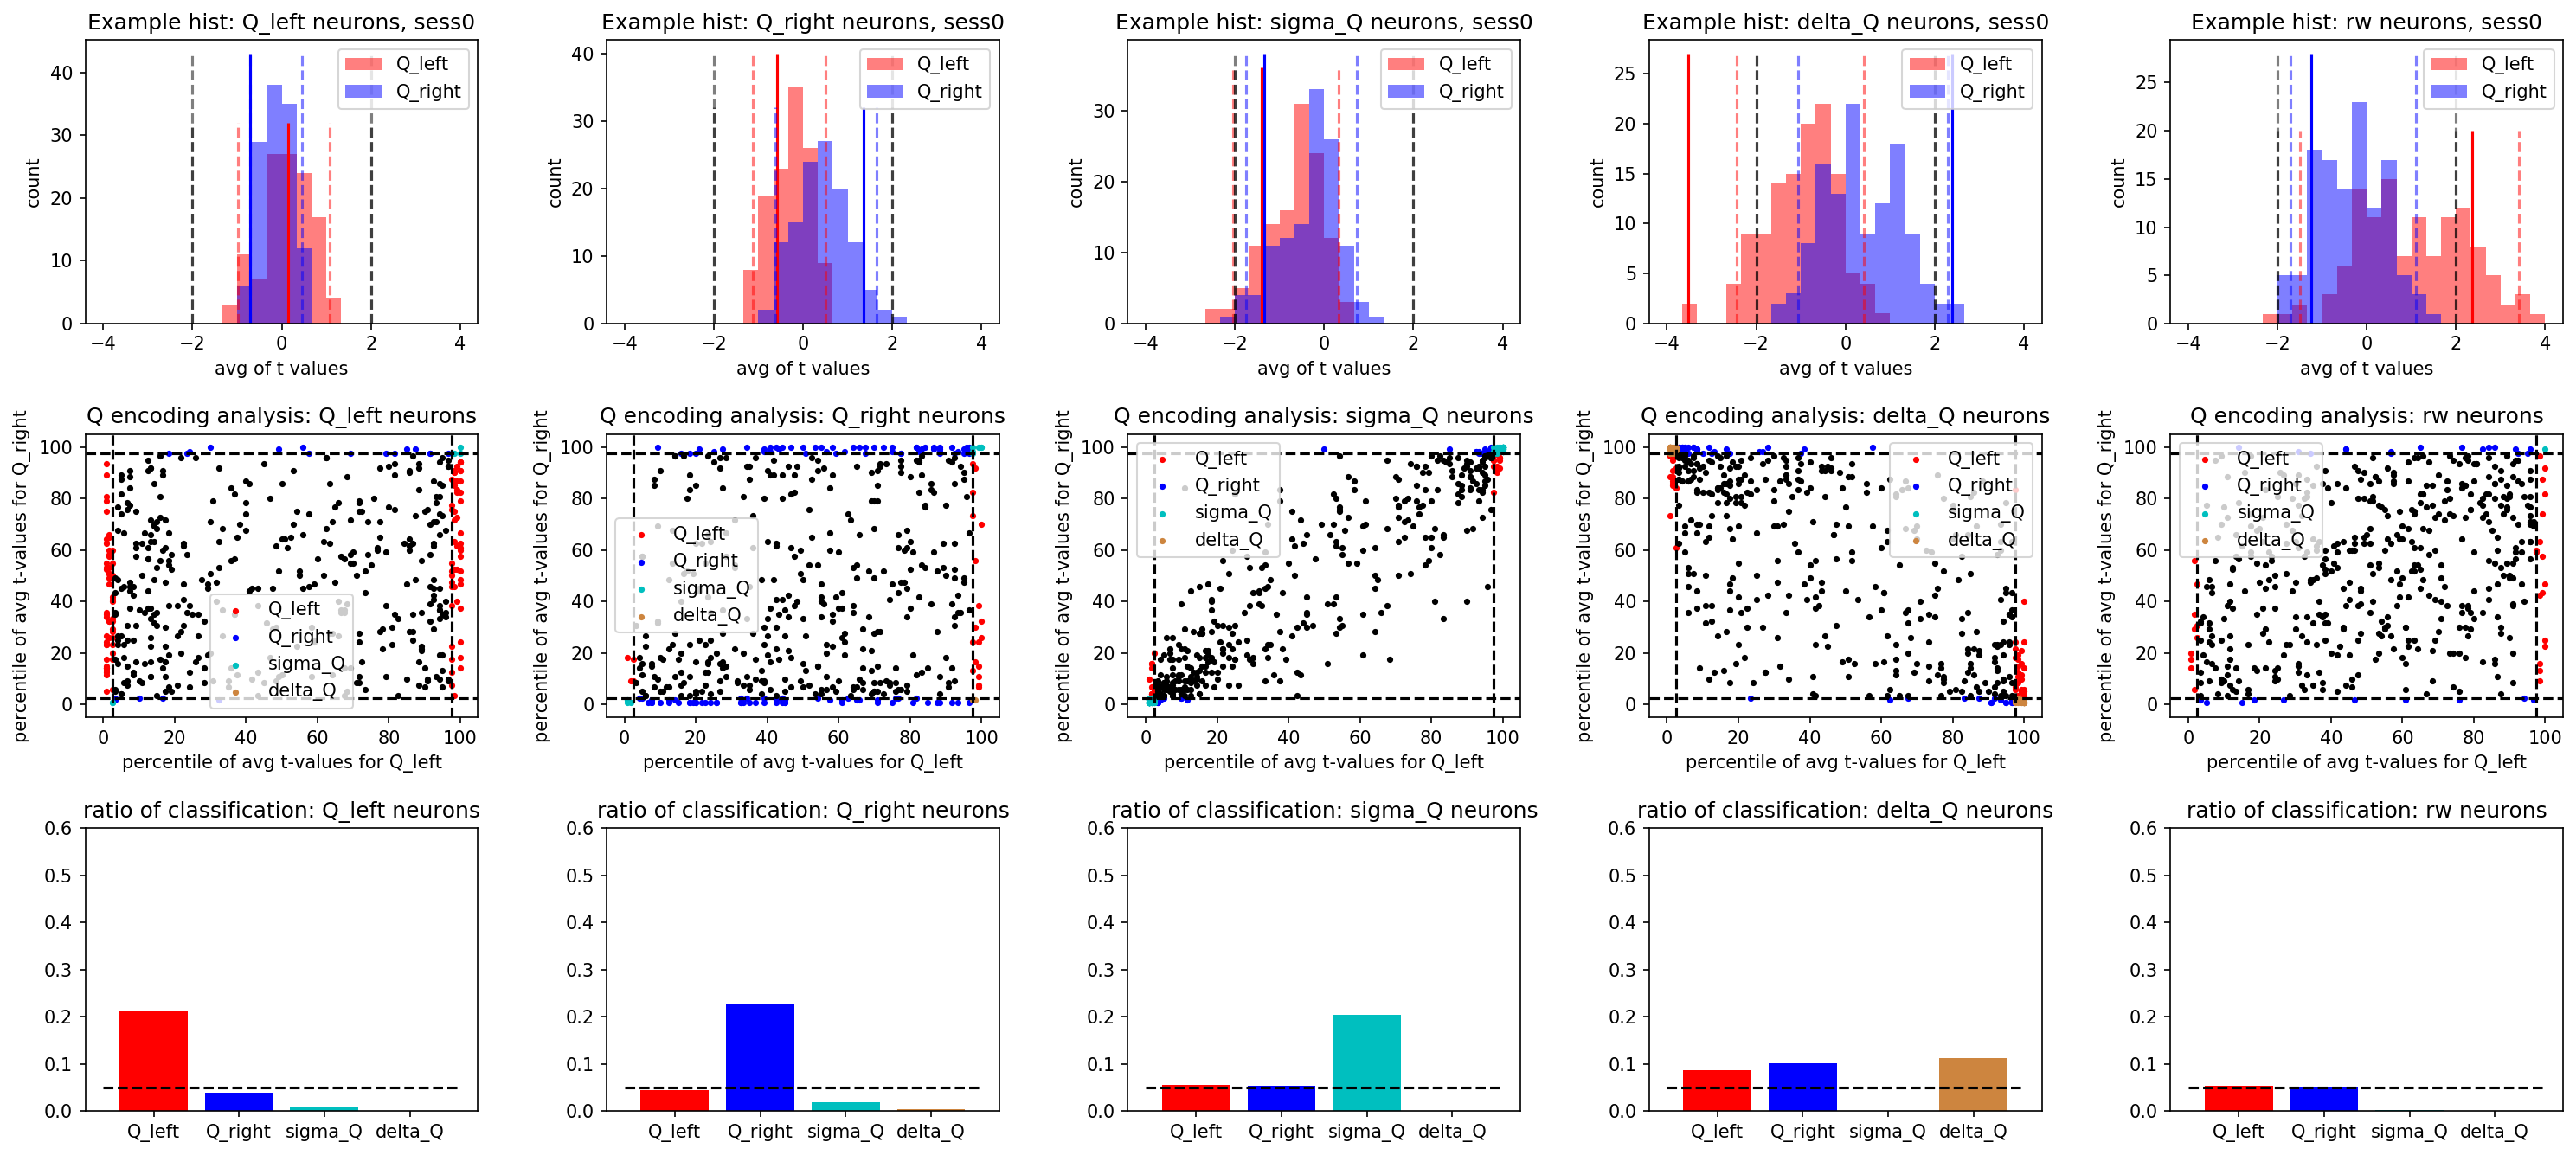

In [3]:
with open('./df_msp_fit_dict.pickle', 'rb') as handle:
    df_msp_fit_dict = pickle.load(handle)

neuron_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q', 'rw']
tvalue_sig_thresh = (-2, 2)

# plot multi_session_permutation fit
percentiles_2_compute = [2.5, 97.5]

hist_lim = (-4, 4)
hist_to_plot_neuron_id = 0
colors = {'Q_left': 'r', 'Q_right': 'b'}

tvalue_percentile_lim = (-5, 105)
dot_size = 6

classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(3, len(neuron_types), figsize=(4*len(neuron_types), 3*3), dpi=150)
for neuron_type_id, neuron_type in enumerate(neuron_types):
    col_ind = neuron_type_id
    df_fit = df_msp_fit_dict[neuron_type]
    
    # calculate percentile of t values of self-fitted sessions
    # based on the ensemble of permutations of sessions
    n_neurons_fitted = len(np.unique(df_fit['neuron_id'].values))
    df_fit_t_percentile_agnt_null = pd.DataFrame(columns=['neuron_id', 'Q_left', 'Q_right'])
    #df_avg_t_percentile = pd.DataFrame(columns=['Q_left', 'Q_right'])

    for n in np.unique(df_fit['neuron_id'].values).astype(np.int):
        df_fit_neuron = df_fit[df_fit['neuron_id']==n]
        t_percentile_agnt_null = [n]
        for i, q_side in enumerate(['Q_left', 'Q_right']):
            tvalues_q_side = np.vstack(df_fit_neuron[f'tvalues_{q_side}'].values[:]).astype(np.float)
            avg_tvalues_q_side = np.average(tvalues_q_side, axis=1)
            # get self fitted permutation
            tvalue_self_q_side = df_fit_neuron[df_fit_neuron['gen_session_perm']==df_fit_neuron['fit_session_perm']][f'tvalues_{q_side}'].iloc[0]
            avg_tvalue_self_q_side = np.average(tvalue_self_q_side)
            
            t_percentile_agnt_null.append(stats.percentileofscore(avg_tvalues_q_side, avg_tvalue_self_q_side))
        
            # plot histogram for one neuron
            if n == hist_to_plot_neuron_id:
                row_ind = 0        
                avg_tvalues_percentile_q_side = np.percentile(avg_tvalues_q_side, percentiles_2_compute)
                hist_q_side, _, _ = axs[row_ind, col_ind].hist(avg_tvalues_q_side, bins=24, range=hist_lim, histtype='stepfilled', 
                                                            color=colors[q_side], label=q_side, alpha=0.5)
                axs[row_ind, col_ind].vlines(avg_tvalue_self_q_side, 0, np.max(hist_q_side)+5, 
                                            color=colors[q_side])
                axs[row_ind, col_ind].vlines(avg_tvalues_percentile_q_side, 0, np.max(hist_q_side)+5, 
                                            color=colors[q_side], linestyle='--', alpha=0.5)
                axs[row_ind, col_ind].vlines(tvalue_sig_thresh, 0, np.max(hist_q_side)+5, 
                                                color='k', linestyle='--', alpha=0.5)

                axs[row_ind, col_ind].set_title(f'Example hist: {neuron_type} neurons, sess{n}')
                axs[row_ind, col_ind].set_xlabel('avg of t values')
                axs[row_ind, col_ind].set_ylabel('count')
                axs[row_ind, col_ind].legend()

        df_fit_t_percentile_agnt_null.loc[len(df_fit_t_percentile_agnt_null.index)] = t_percentile_agnt_null


    # scatter plot of neurons
    row_ind = 1

    # choose tvalue_sig_threshold
    # (-2, 2) for naive case
    # tvalue_sig_threshold = {'Q_left': tvalue_sig_thresh, 'Q_right': tvalue_sig_thresh} 
    # dynamic for adv analysis
    # tvalue_sig_threshold = {'Q_left': tvalues_percentile['Q_left'], 'Q_right': tvalues_percentile['Q_right']} 
    # (2.5, 97.5) for percentile case
    tvalue_sig_threshold = {'Q_left': percentiles_2_compute, 'Q_right': percentiles_2_compute} 

    df_fit_Q_left_sig = df_fit_t_percentile_agnt_null[((df_fit_t_percentile_agnt_null['Q_left']>=tvalue_sig_threshold['Q_left'][1]) | 
                                (df_fit_t_percentile_agnt_null['Q_left']<=tvalue_sig_threshold['Q_left'][0])) & 
                               (df_fit_t_percentile_agnt_null['Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                               (df_fit_t_percentile_agnt_null['Q_right']>tvalue_sig_threshold['Q_right'][0])]
    axs[row_ind, col_ind].scatter(df_fit_Q_left_sig['Q_left'].values, 
                                  df_fit_Q_left_sig['Q_right'].values, 
                                  color='r', s=dot_size, label='Q_left')
    df_fit_Q_right_sig = df_fit_t_percentile_agnt_null[((df_fit_t_percentile_agnt_null['Q_right']>=tvalue_sig_threshold['Q_right'][1]) | 
                                 (df_fit_t_percentile_agnt_null['Q_right']<=tvalue_sig_threshold['Q_right'][0])) & 
                                (df_fit_t_percentile_agnt_null['Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                                (df_fit_t_percentile_agnt_null['Q_left']>tvalue_sig_threshold['Q_left'][0])]
    axs[row_ind, col_ind].scatter(df_fit_Q_right_sig['Q_left'].values, 
                                  df_fit_Q_right_sig['Q_right'].values, 
                                  color='b', s=dot_size, label='Q_right')
    df_fit_sigma_Q_sig = df_fit_t_percentile_agnt_null[((df_fit_t_percentile_agnt_null['Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']>=tvalue_sig_threshold['Q_right'][1])) | 
                                ((df_fit_t_percentile_agnt_null['Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']<=tvalue_sig_threshold['Q_right'][0]))]
    axs[row_ind, col_ind].scatter(df_fit_sigma_Q_sig['Q_left'].values, 
                                  df_fit_sigma_Q_sig['Q_right'].values, 
                                  color='c', s=dot_size, label='sigma_Q')
    df_fit_delta_Q_sig = df_fit_t_percentile_agnt_null[((df_fit_t_percentile_agnt_null['Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']<=tvalue_sig_threshold['Q_right'][0])) | 
                                ((df_fit_t_percentile_agnt_null['Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']>=tvalue_sig_threshold['Q_right'][1]))]
    axs[row_ind, col_ind].scatter(df_fit_delta_Q_sig['Q_left'].values, 
                                  df_fit_delta_Q_sig['Q_right'].values, 
                                  color='peru', s=dot_size, label='delta_Q')
    df_fit_null = df_fit_t_percentile_agnt_null[(df_fit_t_percentile_agnt_null['Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                         (df_fit_t_percentile_agnt_null['Q_left']>tvalue_sig_threshold['Q_left'][0]) & 
                         (df_fit_t_percentile_agnt_null['Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                         (df_fit_t_percentile_agnt_null['Q_right']>tvalue_sig_threshold['Q_right'][0])]
    axs[row_ind, col_ind].scatter(df_fit_null['Q_left'].values, 
                                  df_fit_null['Q_right'].values, 
                                  color='k', s=dot_size)
    sum_classified_neurons = len(df_fit_Q_left_sig)+len(df_fit_Q_right_sig)+ \
                             len(df_fit_sigma_Q_sig)+len(df_fit_delta_Q_sig)+ \
                             len(df_fit_null)
    if len(df_fit_t_percentile_agnt_null) != sum_classified_neurons:
        raise ValueError(f'sum of dots doesnt match: {len(df_fit_t_percentile_agnt_null)} {sum_classified_neurons}')

    axs[row_ind, col_ind].hlines(tvalue_sig_threshold['Q_left'], tvalue_percentile_lim[0], tvalue_percentile_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].vlines(tvalue_sig_threshold['Q_left'], tvalue_percentile_lim[0], tvalue_percentile_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'Q encoding analysis: {neuron_type} neurons')
    axs[row_ind, col_ind].set_xlim(tvalue_percentile_lim[0], tvalue_percentile_lim[1])
    axs[row_ind, col_ind].set_ylim(tvalue_percentile_lim[0], tvalue_percentile_lim[1])
    axs[row_ind, col_ind].set_xlabel('percentile of avg t-values for Q_left')
    axs[row_ind, col_ind].set_ylabel('percentile of avg t-values for Q_right')
    axs[row_ind, col_ind].legend()


    # bar plot for significant neurons
    row_ind = 2
    print(f'{neuron_type} total dots: {len(df_fit_t_percentile_agnt_null)}')
    print(f' classified Q_left: {len(df_fit_Q_left_sig)}')
    print(f' classified Q_right: {len(df_fit_Q_right_sig)}')
    print(f' classified sigma_Q: {len(df_fit_sigma_Q_sig)}')
    print(f' classified delta_Q: {len(df_fit_delta_Q_sig)}')
    
    classified_ratios = [
        len(df_fit_Q_left_sig)/ float(len(df_fit_t_percentile_agnt_null)),
        len(df_fit_Q_right_sig)/ float(len(df_fit_t_percentile_agnt_null)),
        len(df_fit_sigma_Q_sig)/ float(len(df_fit_t_percentile_agnt_null)),
        len(df_fit_delta_Q_sig)/ float(len(df_fit_t_percentile_agnt_null))]
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of classification: {neuron_type} neurons')
    axs[row_ind, col_ind].set_ylim(0, 0.6)

plt.tight_layout()

In [9]:
with open('./msp_sim_neurons.pickle', 'rb') as handle:
    msp_sim_neurons = pickle.load(handle)

neuron_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q', 'rw']
sim_neuron_columns = ['session', 'neuron_id', 'firing_rates']

# pool of neurons
pool_types = ['LR', 'LRS', 'LRD', 'LRSD', 'LRSDW']
neuron_type_abbreviation_lut = {'L': 'Q_left', 'R': 'Q_right', 
    'S': 'sigma_Q', 'D': 'delta_Q', 'W': 'rw'}

pool_neurons = {pool_type: pd.DataFrame(columns=sim_neuron_columns) for pool_type in pool_types}

for pool_type in pool_types:
    for neuon_abb in pool_type:
        pool_neurons[pool_type] = pd.concat([pool_neurons[pool_type], msp_sim_neurons[neuron_type_abbreviation_lut[neuon_abb]]])

In [15]:
# multi_session_permutation fit of pool neurons
# compute the test statistic: avg t values of regression
# in all possible permutations

sessions = [38, 39, 40, 42, 45]

session_len = []
for session in sessions:
    df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
    session_len.append(len(df_Qs_session))

print(f'min session {session_len.index(min(session_len))} len: {min(session_len)}, max session {session_len.index(max(session_len))} len: {max(session_len)}')
len_min = min(session_len)


msp_fit_columns = ['gen_session_perm', 'neuron_id', 'fit_session_perm', 'tvalues_Q_left', 'tvalues_Q_right']
df_msp_fit_pool_dict = {pool_type: pd.DataFrame(columns=msp_fit_columns) for pool_type in pool_types}

# fit on all permutations of sessions
# single neuron, present in all sessions

for j, p in enumerate(itertools.permutations(range(len(sessions)))):
    print(f'permutation {j}: {p}')
    
    for pool_type in pool_types:
        neurons = pool_neurons[pool_type]
        df_msp_fit_pool = df_msp_fit_pool_dict[pool_type]
        
        for j in range(len(pool_type)):
            #for n in range(len(neurons)):
            for n in range(3):

                gen_session_perm = []
                fit_session_perm = []
                tvalues_Q_left = []
                tvalues_Q_right = []

                for session_id in range(len(sessions)):
                    gen_session = sessions[session_id]
                    fit_session = sessions[p[session_id]]
                    gen_session_perm.append(gen_session)
                    fit_session_perm.append(fit_session)
                    # print(f' using gen_session {gen_session} and fit_session {fit_session}')

                    # get Qs
                    df_Qs_session = df_Qs[df_Qs['session']==fit_session].sort_values(by=['trial'])
                    X_fit = df_Qs_session[['Q_left', 'Q_right']]
                    X_fit = sm.add_constant(X_fit)
                    X_fit = X_fit[:len_min]
                    # print(f' session {fit_session}: {X_fit.shape}')

                    
                    fr = neurons[(neurons['session']==gen_session) & 
                                (neurons['neuron_id']==n)]['firing_rates'].values[0][:len_min]
                    model = sm.OLS(fr, X_fit)
                    results = model.fit()
                    tvalues_Q_left.append(results.tvalues['Q_left'])
                    tvalues_Q_right.append(results.tvalues['Q_right'])

                tvalues_Q_left = np.array(tvalues_Q_left)
                tvalues_Q_right = np.array(tvalues_Q_right)
                df_msp_fit_pool.loc[len(df_msp_fit_pool.index)] = [gen_session_perm, n, fit_session_perm, 
                                                                tvalues_Q_left, tvalues_Q_right]

min session 0 len: 468, max session 3 len: 1143
permutation 0: (0, 1, 2, 3, 4)
permutation 1: (0, 1, 2, 4, 3)
permutation 2: (0, 1, 3, 2, 4)
permutation 3: (0, 1, 3, 4, 2)
permutation 4: (0, 1, 4, 2, 3)
permutation 5: (0, 1, 4, 3, 2)
permutation 6: (0, 2, 1, 3, 4)
permutation 7: (0, 2, 1, 4, 3)
permutation 8: (0, 2, 3, 1, 4)
permutation 9: (0, 2, 3, 4, 1)
permutation 10: (0, 2, 4, 1, 3)
permutation 11: (0, 2, 4, 3, 1)
permutation 12: (0, 3, 1, 2, 4)
permutation 13: (0, 3, 1, 4, 2)
permutation 14: (0, 3, 2, 1, 4)
permutation 15: (0, 3, 2, 4, 1)
permutation 16: (0, 3, 4, 1, 2)
permutation 17: (0, 3, 4, 2, 1)
permutation 18: (0, 4, 1, 2, 3)
permutation 19: (0, 4, 1, 3, 2)
permutation 20: (0, 4, 2, 1, 3)
permutation 21: (0, 4, 2, 3, 1)
permutation 22: (0, 4, 3, 1, 2)
permutation 23: (0, 4, 3, 2, 1)
permutation 24: (1, 0, 2, 3, 4)
permutation 25: (1, 0, 2, 4, 3)
permutation 26: (1, 0, 3, 2, 4)
permutation 27: (1, 0, 3, 4, 2)
permutation 28: (1, 0, 4, 2, 3)
permutation 29: (1, 0, 4, 3, 2)
pe

In [ ]:
# alternatively, combine fitted table

### Pseudo sessio method

In [8]:
def get_block_lengths(p_reward_trial, p_reward_block):
    block_switch_trial = [0]
    for block_ind in range(p_reward_block.shape[1]):
        trials = np.where((p_reward_trial[0] == p_reward_block[0, block_ind]) & 
                          (p_reward_trial[1] == p_reward_block[1, block_ind]) &
                          [False if t<block_switch_trial[-1] else True for t in range(p_reward_trial.shape[1])])[0]
        # print(f'{block_ind}: {trials}')
        # print(f' {np.where(np.diff(trials) > 1)}')
        if len(np.where(np.diff(trials) > 1)[0])>0:
            trials_first_switch_ind = np.where(np.diff(trials) > 1)[0][0] + 1
            block = trials[: trials_first_switch_ind]
        else:
            block = trials
        # print(f' {block}')
        block_switch_trial.append(block[-1]+1)
    
    block_switch_trial = np.array(block_switch_trial)
    block_lengths = np.diff(block_switch_trial)

    return block_lengths, block_switch_trial


def gen_p_reward_sequence(p_reward_trial, p_reward_block, block_lengths, 
                          block_generator_spread=5, seed=None, plot=False):
    
    p_reward_gen = np.empty((p_reward_trial.shape[0], p_reward_trial.shape[1]+1))
    #print(f'p_reward_block shape: {p_reward_block.shape}')
    #print(f'p_reward_gen shape: {p_reward_gen.shape}')

    # generate new block lengths
    if seed:
        np.random.seed(seed)
    
    not_all_positive = True
    while not_all_positive:
        block_length_generator = np.rint(np.random.uniform(
                                            -1*block_generator_spread+0.1, 
                                            block_generator_spread+0.1, 
                                            size=len(block_lengths)-1)).astype(np.int)
        block_length_generator = np.append(block_length_generator, -1*np.sum(block_length_generator))
        block_lengths_gen = (block_lengths + block_length_generator).astype(np.int)
        not_all_positive = np.any(block_lengths_gen<=0)
        
    #print(f'original block lengths: {block_lengths}')
    #print(f'generated new block length: {block_lengths_gen}')
    #print(f'check total trial number: {np.sum(block_lengths_gen)}')
    
    # generate new p_reward arr
    for i in range(p_reward_trial.shape[0]):
        for block_gen_ind in range(len(block_lengths_gen)):
            if block_gen_ind == 0:
                p_reward_gen[i, 0:block_lengths_gen[block_gen_ind]] = p_reward_block[i, block_gen_ind]
            else:
                t_start = np.sum(block_lengths_gen[:block_gen_ind])
                p_reward_gen[i, t_start:t_start+block_lengths_gen[block_gen_ind]] = p_reward_block[i, block_gen_ind]
        p_reward_gen[i, -1] = p_reward_gen[i, -2]

    if plot:
        sides = ['left', 'right']
        colors = ['r', 'b']
        plt.figure(figsize=(8,4), dpi=150)
        for i in range(p_reward_trial.shape[0]):
            plt.plot(p_reward_trial[i], color=colors[i], label=f'original {sides[i]}')
            plt.plot(p_reward_gen[i], color=colors[i], linestyle='--', label=f'generated {sides[i]}')
            plt.title(f'Generated reward rate blocks')
            plt.xlabel('trial')
            plt.ylabel('reward_rate')
        plt.legend(bbox_to_anchor=(1, 0.6))
        plt.tight_layout()
            
    return p_reward_gen, block_lengths_gen


def gen_p_reward_sequence_random_block(forager, block_lengths):
    block_length_avg = np.average(block_lengths)
    block_length_std = np.std(block_lengths)

    forager.generate_p_reward(block_length_avg, block_length_std)

    return forager

In [18]:
def gen_qs_by_fitted_model(key, p_reward_trial, p_reward_block, block_lengths, 
                           gen_type='random_block_struct', block_generator_spread=5, forager_type='LNP_softmax'):
    
    # gen_type: ['random_block_struct', 'same_block_struct']
    # by default: random_block_struct

    # get fitted model
    model_para = pd.DataFrame((foraging_model.FittedSessionModel.Param & key).fetch())
    model_para_dict = {}
    for i in range(len(model_para)):
        model_para_dict[model_para.iloc[i]['model_param']] = model_para.iloc[i]['fitted_value']
        
    forager = bandit_model.BanditModel(forager=forager_type, n_trials=int((p_reward_trial).shape[1]), 
                                    **model_para_dict)
    #for k, v in vars(forager).items():
    #    if v is not None:
    #        print(f'{k}: {v}')
    if gen_type == 'random_block_struct':
        forager.generate_p_reward()
        print('simulating forager')
        forager.simulate()
    
    
    elif gen_type == 'same_block_struct':
        # generate reward sequence
        p_reward_gen, block_lengths_gen = gen_p_reward_same_block_struct(p_reward_trial, p_reward_block, block_lengths, 
                                            block_generator_spread=block_generator_spread, plot=False)
        forager.n_blocks = len(block_lengths)
        forager.p_reward = p_reward_gen
        forager.block_size = block_lengths_gen
        forager.p_reward_fraction = p_reward_gen[1]/ np.sum(p_reward_gen, axis=0)
        forager.p_reward_ratio = p_reward_gen[1]/ p_reward_gen[0]

        # generative mode
        # Initialization
        forager.time = 0

        # All latent variables have n_trials + 1 length to capture the update after the last trial (HH20210726)
        forager.q_estimation = np.full([forager.K, forager.n_trials+1], np.nan)
        forager.q_estimation[:, 0] = 0

        forager.choice_prob = np.full([forager.K, forager.n_trials+1], np.nan)
        forager.choice_prob[:, 0] = 1/forager.K   # To be strict (actually no use)

        forager.choice_history = np.zeros(
                        [1, forager.n_trials+1], dtype=int)  # Choice history
        # Reward history, separated for each port (Corrado Newsome 2005)
        forager.reward_history = np.zeros([forager.K, forager.n_trials+1])

        forager.reward_available = np.zeros([forager.K, forager.n_trials+1])
        forager.reward_available[:, 0] = (np.random.uniform(0, 1, forager.K) < forager.p_reward[:, forager.time]).astype(int)

        if forager.forager in ['LNP_softmax', 'LNP_softmax_CK']:
            # Compute the history filter. Compatible with any number of taus.
            # Use the full length of the session just in case of an extremely large tau.
            reversed_t = np.flipud(np.arange(forager.n_trials+1))
            forager.history_filter = np.zeros_like(reversed_t).astype('float64')
            for tau, w_tau in zip(forager.taus, forager.w_taus):
                # Note the normalization term (= tau when n -> inf.)
                forager.history_filter += w_tau * \
                                        np.exp(-reversed_t / tau) / \
                                        np.sum(np.exp(-reversed_t / tau))

        for t in range(forager.n_trials):
            action = forager.act()
            forager.step(action)
    
    else:
        raise ValueError('wrong gen_type for q generation')

    return forager.q_estimation

In [10]:
# generate session action-reward sequence
key = {'subject_id': 482353, 'session': 38, 'model_id': 10}
sessions = [key['session']]

# get fitted q variables
q_latent_variable = (foraging_model.FittedSessionModel.TrialLatentVariable & key)

df_Q = pd.DataFrame(q_latent_variable.fetch())
df_Q_left = df_Q[df_Q['water_port']=='left']#.sort_values(by=['trial'])
df_Q_right = df_Q[df_Q['water_port']=='right']#.sort_values(by=['trial'])

# get only Qs columns
df_Q_right = df_Q_right[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_right'})#.reset_index(drop=True)
df_Q_left = df_Q_left[['session', 'trial', 'action_value']].rename(columns={'action_value': 'Q_left'})#.reset_index(drop=True)
df_Qs = df_Q_left.merge(df_Q_right)


# get session history
p_reward_block_df = pd.DataFrame((experiment.SessionBlock.WaterPortRewardProbability() & key).fetch())
p_reward_block_left = p_reward_block_df[p_reward_block_df['water_port']=='left'].sort_values(by='block')['reward_probability'].values
p_reward_block_right = p_reward_block_df[p_reward_block_df['water_port']=='right'].sort_values(by='block')['reward_probability'].values
p_reward_block = np.vstack((p_reward_block_left, p_reward_block_right)).astype(np.float)

blocks = np.unique(p_reward_block_df['block'].values)
if np.max(blocks) != len(blocks):
    raise ValueError('missing blocks!')
else:
    n_blocks = len(blocks)

choice_history, reward_history, _, p_reward_trial, q_choice_outcome = foraging_model.get_session_history(key, remove_ignored=True)
block_lengths, _ = get_block_lengths(p_reward_trial, p_reward_block)

In [11]:
q_est = gen_qs_by_fitted_model(key, p_reward_trial, p_reward_block, block_lengths, block_generator_spread=0)

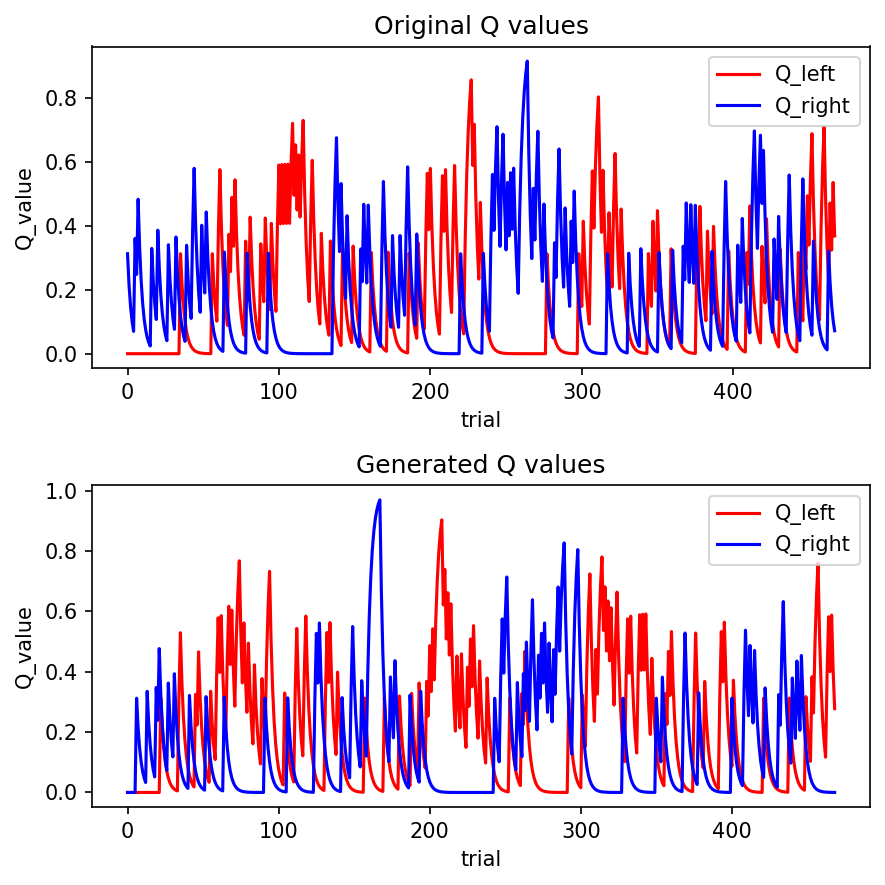

In [12]:
# plot q_estimation
qs = ['Q_left', 'Q_right']
colors = ['r', 'b']
fig, axs = plt.subplots(2,1, figsize=(6,6), dpi=150)
for i, q in enumerate(qs):
    axs[0].plot(df_Qs[df_Qs['session']==key['session']][q].values, color=colors[i], label=q)
    axs[1].plot(q_est[i], color=colors[i], label=q)
axs[0].set_title('Original Q values')
axs[1].set_title('Generated Q values')
for j in range(len(axs)):
    axs[j].set_xlabel('trial')
    axs[j].set_ylabel('Q_value')
    axs[j].legend(loc='best')
plt.tight_layout()

In [11]:
# generate simulated neurons
n_neurons = 300
neuron_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q', 'rw']

sim_neuron_columns = ['session', 'neuron_id', 'firing_rates']
sim_neurons = {neuron_type: pd.DataFrame(columns=sim_neuron_columns) for neuron_type in neuron_types}

for n in range(n_neurons):

    for gen_session in sessions:
        df_Qs_session = df_Qs[df_Qs['session']==gen_session].sort_values(by=['trial'])
        X = df_Qs_session[['Q_left', 'Q_right']]
        print(f'session {gen_session}: {X.shape}')

        for neuron_type in neuron_types:
            if neuron_type in ['Q_left', 'Q_right']:
                fr = gen_action_value_neuron(X[neuron_type].values)
            elif neuron_type == 'sigma_Q':
                fr = gen_action_value_neuron(X['Q_left'].values + X['Q_right'].values)
            elif neuron_type == 'delta_Q':
                fr = gen_action_value_neuron(X['Q_left'].values - X['Q_right'].values)
            elif neuron_type == 'rw':
                fr = gen_random_walk_neuron(len(X))
            else:
                raise ValueError('wrong neuron types!')
            sim_neurons[neuron_type].loc[len(sim_neurons[neuron_type].index)] = [gen_session, n, fr]

session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (468, 2)
session 38: (

In [33]:
# naive fit
naive_fit_columns = ['gen_session', 'neuron_id', 'fit_session', 'tvalues_Q_left', 'tvalues_Q_right']
df_naive_fit_dict = {neuron_type: pd.DataFrame(columns=naive_fit_columns) for neuron_type in neuron_types}

# fit simulated neurons
for session in sessions:
    df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
    X = df_Qs_session[['Q_left', 'Q_right']]
    X = sm.add_constant(X)
    print(f'session {session}: {X.shape}')

    for n in range(n_neurons):
        
        for neuron_type in neuron_types:
            neurons = sim_neurons[neuron_type]
            df_naive_fit = df_naive_fit_dict[neuron_type]
            # action neurons
            fr = neurons[(neurons['session']==session) & (neurons['neuron_id']==n)]['firing_rates'].values[0]
            model = sm.OLS(fr, X)
            results = model.fit()
            df_naive_fit.loc[len(df_naive_fit.index)] = [session, n, session, results.tvalues['Q_left'], results.tvalues['Q_right']]

session 38: (468, 3)


Q_left total dots: 300
 classified Q_left: 171
 classified Q_right: 7
 classified sigma_Q: 4
 classified delta_Q: 2
Q_right total dots: 300
 classified Q_left: 6
 classified Q_right: 162
 classified sigma_Q: 6
 classified delta_Q: 2
sigma_Q total dots: 300
 classified Q_left: 22
 classified Q_right: 31
 classified sigma_Q: 152
 classified delta_Q: 0
delta_Q total dots: 300
 classified Q_left: 44
 classified Q_right: 31
 classified sigma_Q: 0
 classified delta_Q: 146
rw total dots: 300
 classified Q_left: 45
 classified Q_right: 78
 classified sigma_Q: 105
 classified delta_Q: 10


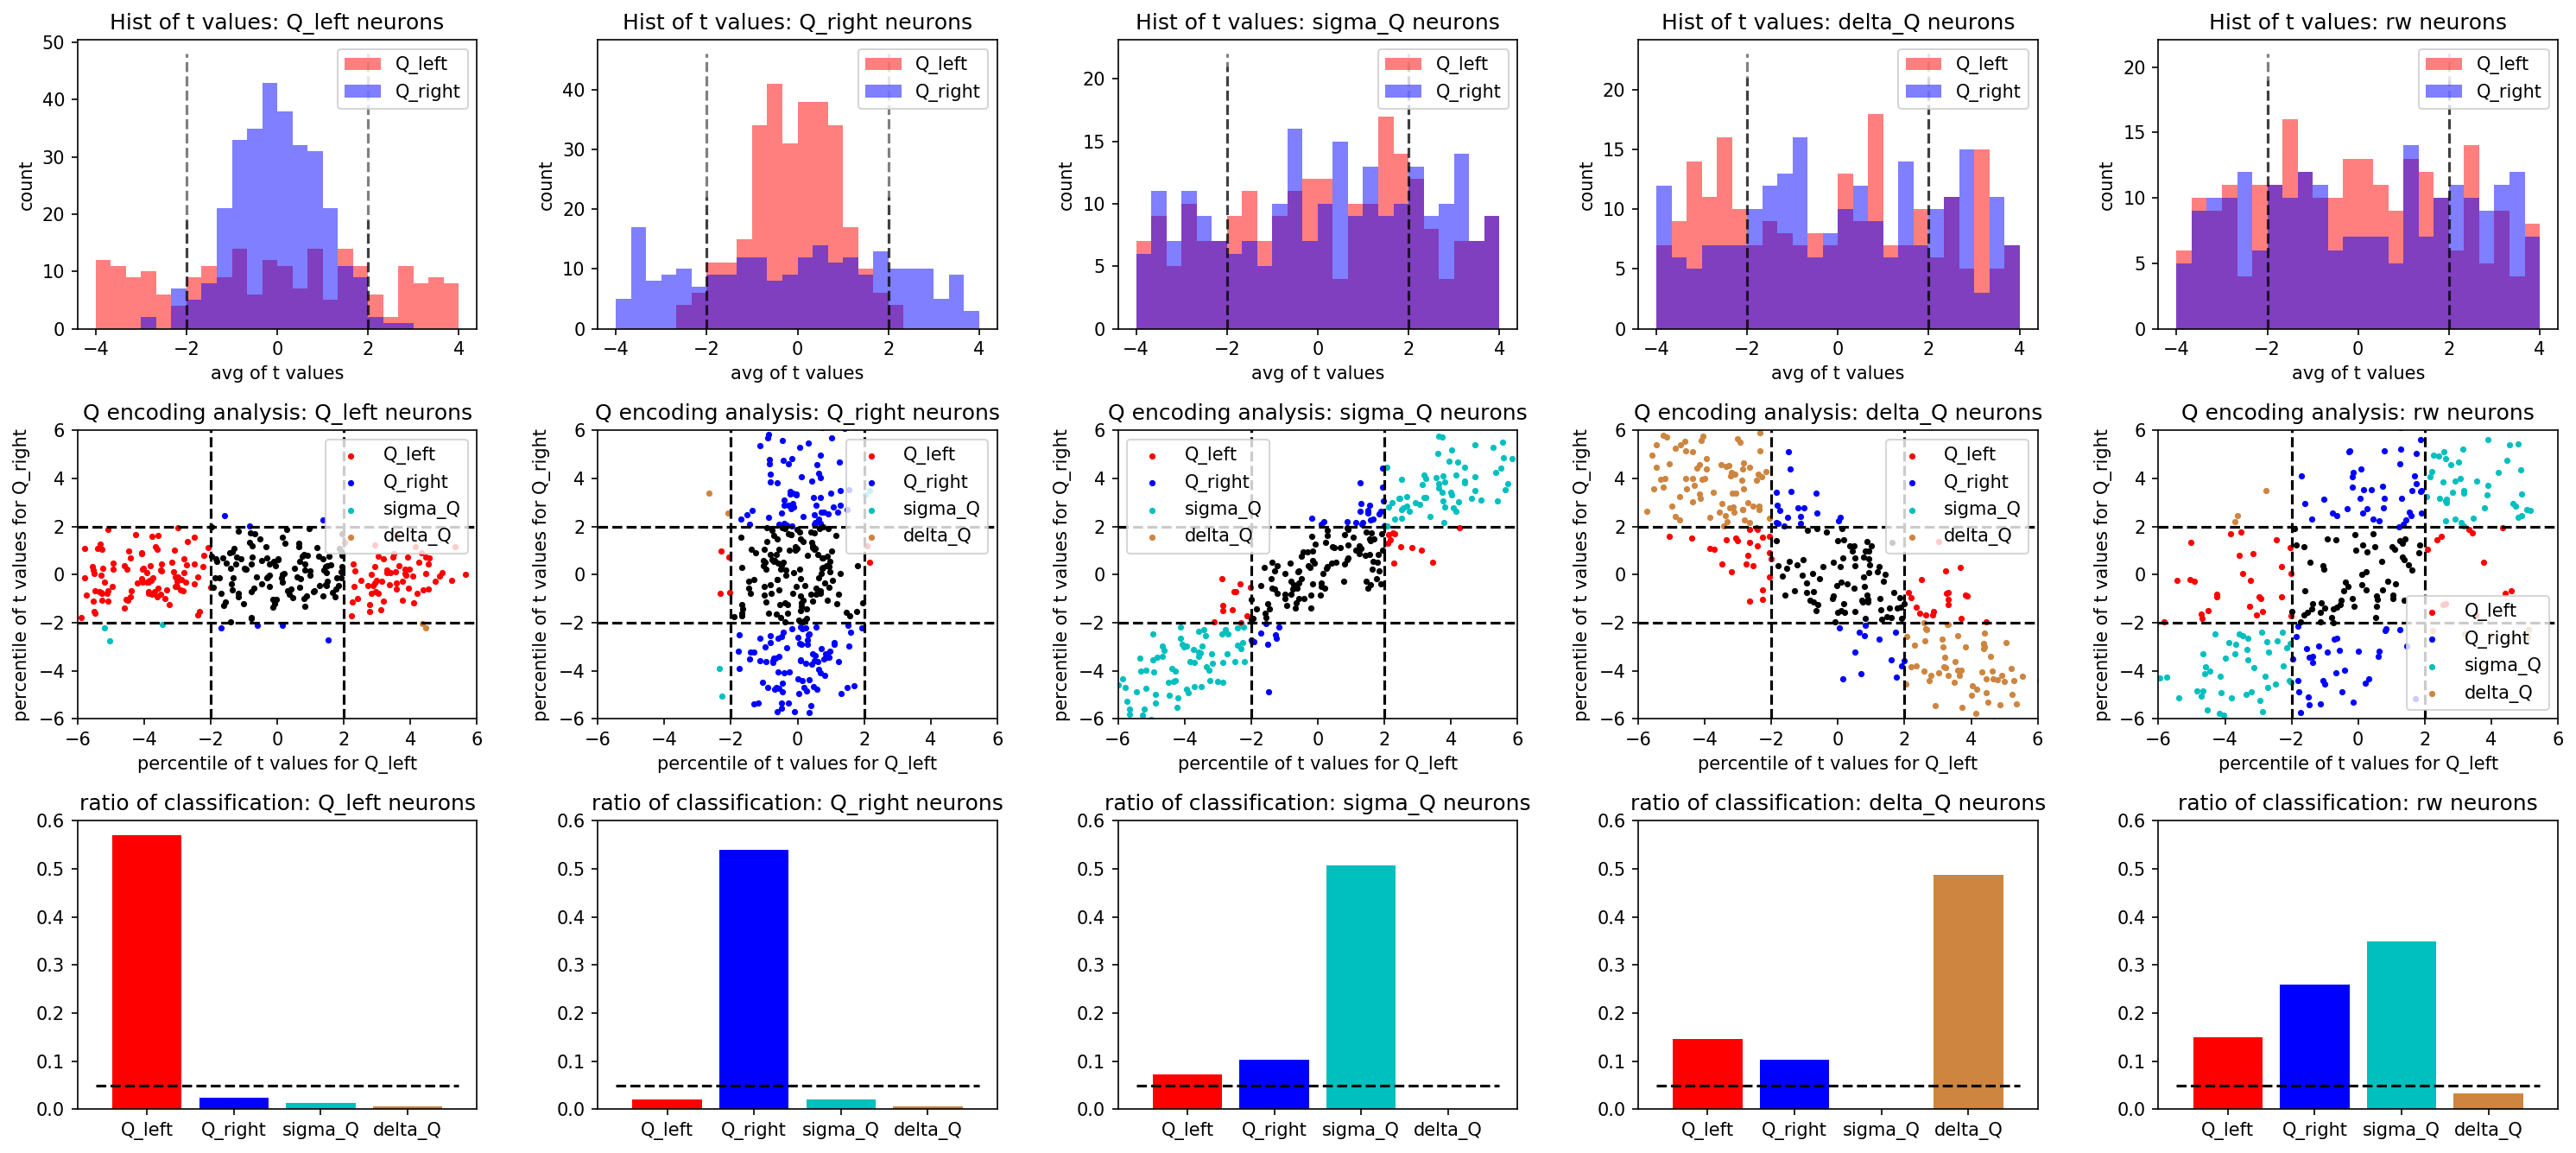

In [38]:
# plot naive fit
percentiles_2_compute = [2.5, 97.5]

colors = {'Q_left': 'r', 'Q_right': 'b'}
hist_lim = (-4, 4)
hist_top = 40

tvalue_lim = (-6, 6)
tvalue_sig_thresh = (-2, 2)
dot_size = 6

classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(3, len(neuron_types), figsize=(4*len(neuron_types), 3*3), dpi=150)
for neuron_type_id, neuron_type in enumerate(neuron_types):
    col_ind = neuron_type_id

    df_fit = df_naive_fit_dict[neuron_type]
    tvalues_percentile = {'Q_left': None, 'Q_right': None}
    # histogram of regression tvalues
    row_ind = 0
    for i, q_side in enumerate(['Q_left', 'Q_right']):
        tvalues_q_side = df_fit[f'tvalues_{q_side}'].values
        tvalues_percentile_q_side = np.percentile(tvalues_q_side, percentiles_2_compute)
        tvalues_percentile[q_side] = tvalues_percentile_q_side
        hist_q_side, _, _ = axs[row_ind, col_ind].hist(tvalues_q_side, bins=24, range=hist_lim, histtype='stepfilled', 
                                                       color=colors[q_side], label=q_side, alpha=0.5)
        axs[row_ind, col_ind].vlines(tvalue_sig_thresh, 0, np.max(hist_q_side)+5, 
                                     color='k', linestyle='--', alpha=0.5)
        #axs[row_ind, col_ind].vlines(tvalues_percentile_q_side, 0, hist_top, 
        #                             color=colors[q_side], linestyle='--', alpha=0.5)

    axs[row_ind, col_ind].set_title(f'Hist of t values: {neuron_type} neurons')
    axs[row_ind, col_ind].set_xlabel('t value')
    axs[row_ind, col_ind].set_ylabel('count')
    axs[row_ind, col_ind].legend()

    
    # scatter plot of neurons
    row_ind = 1
    # choose tvalue_sig_threshold
    # (-2, 2) for naive case
    tvalue_sig_threshold = {'Q_left': tvalue_sig_thresh, 'Q_right': tvalue_sig_thresh} 
    # dynamic for adv analysis
    # tvalue_sig_threshold = {'Q_left': tvalues_percentile['Q_left'], 'Q_right': tvalues_percentile['Q_right']} 
    df_fit_Q_left_sig = df_fit[((df_fit['tvalues_Q_left']>=tvalue_sig_threshold['Q_left'][1]) | 
                                (df_fit['tvalues_Q_left']<=tvalue_sig_threshold['Q_left'][0])) & 
                               (df_fit['tvalues_Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                               (df_fit['tvalues_Q_right']>tvalue_sig_threshold['Q_right'][0])]
    axs[row_ind, col_ind].scatter(df_fit_Q_left_sig['tvalues_Q_left'].values, 
                                  df_fit_Q_left_sig['tvalues_Q_right'].values, 
                                  color='r', s=dot_size, label='Q_left')
    df_fit_Q_right_sig = df_fit[((df_fit['tvalues_Q_right']>=tvalue_sig_threshold['Q_right'][1]) | 
                                 (df_fit['tvalues_Q_right']<=tvalue_sig_threshold['Q_right'][0])) & 
                                (df_fit['tvalues_Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                                (df_fit['tvalues_Q_left']>tvalue_sig_threshold['Q_left'][0])]
    axs[row_ind, col_ind].scatter(df_fit_Q_right_sig['tvalues_Q_left'].values, 
                                  df_fit_Q_right_sig['tvalues_Q_right'].values, 
                                  color='b', s=dot_size, label='Q_right')
    df_fit_sigma_Q_sig = df_fit[((df_fit['tvalues_Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit['tvalues_Q_right']>=tvalue_sig_threshold['Q_right'][1])) | 
                                ((df_fit['tvalues_Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit['tvalues_Q_right']<=tvalue_sig_threshold['Q_right'][0]))]
    axs[row_ind, col_ind].scatter(df_fit_sigma_Q_sig['tvalues_Q_left'].values, 
                                  df_fit_sigma_Q_sig['tvalues_Q_right'].values, 
                                  color='c', s=dot_size, label='sigma_Q')
    df_fit_delta_Q_sig = df_fit[((df_fit['tvalues_Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit['tvalues_Q_right']<=tvalue_sig_threshold['Q_right'][0])) | 
                                ((df_fit['tvalues_Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit['tvalues_Q_right']>=tvalue_sig_threshold['Q_right'][1]))]
    axs[row_ind, col_ind].scatter(df_fit_delta_Q_sig['tvalues_Q_left'].values, 
                                  df_fit_delta_Q_sig['tvalues_Q_right'].values, 
                                  color='peru', s=dot_size, label='delta_Q')
    df_fit_null = df_fit[(df_fit['tvalues_Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                         (df_fit['tvalues_Q_left']>tvalue_sig_threshold['Q_left'][0]) & 
                         (df_fit['tvalues_Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                         (df_fit['tvalues_Q_right']>tvalue_sig_threshold['Q_right'][0])]
    axs[row_ind, col_ind].scatter(df_fit_null['tvalues_Q_left'].values, 
                                  df_fit_null['tvalues_Q_right'].values, 
                                  color='k', s=dot_size)
    sum_classified_neurons = len(df_fit_Q_left_sig)+len(df_fit_Q_right_sig)+ \
                             len(df_fit_sigma_Q_sig)+len(df_fit_delta_Q_sig)+ \
                             len(df_fit_null)
    if len(df_fit) != sum_classified_neurons:
        raise ValueError(f'sum of dots doesnt match: {len(df_fit)} {sum_classified_neurons}')

    axs[row_ind, col_ind].hlines(tvalue_sig_thresh, tvalue_lim[0], tvalue_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].vlines(tvalue_sig_thresh, tvalue_lim[0], tvalue_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'Q encoding analysis: {neuron_type} neurons')
    axs[row_ind, col_ind].set_xlim(tvalue_lim[0], tvalue_lim[1])
    axs[row_ind, col_ind].set_ylim(tvalue_lim[0], tvalue_lim[1])
    axs[row_ind, col_ind].set_xlabel('percentile of t values for Q_left')
    axs[row_ind, col_ind].set_ylabel('percentile of t values for Q_right')
    axs[row_ind, col_ind].legend()


    # bar plot for significant neurons
    row_ind=2
    
    print(f'{neuron_type} total dots: {len(df_fit)}')
    print(f' classified Q_left: {len(df_fit_Q_left_sig)}')
    print(f' classified Q_right: {len(df_fit_Q_right_sig)}')
    print(f' classified sigma_Q: {len(df_fit_sigma_Q_sig)}')
    print(f' classified delta_Q: {len(df_fit_delta_Q_sig)}')
    classified_ratios = [
        len(df_fit_Q_left_sig)/ float(len(df_fit)),
        len(df_fit_Q_right_sig)/ float(len(df_fit)),
        len(df_fit_sigma_Q_sig)/ float(len(df_fit)),
        len(df_fit_delta_Q_sig)/ float(len(df_fit))]
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of classification: {neuron_type} neurons')
    axs[row_ind, col_ind].set_ylim(0, 0.6)

plt.tight_layout()

In [39]:
# pool of neurons
pool_types = ['LR', 'LRS', 'LRD', 'LRSD', 'LRSDW']
neuron_type_abbreviation_lut = {'L': 'Q_left', 'R': 'Q_right', 
    'S': 'sigma_Q', 'D': 'delta_Q', 'W': 'rw'}

pool_neurons = {pool_type: pd.DataFrame(columns=sim_neuron_columns) for pool_type in pool_types}

for pool_type in pool_types:
    for neuon_abb in pool_type:
        pool_neurons[pool_type] = pd.concat([pool_neurons[pool_type], sim_neurons[neuron_type_abbreviation_lut[neuon_abb]]])

In [43]:
# naive fit of pool neuronds
naive_fit_columns = ['gen_session', 'neuron_id', 'fit_session', 'tvalues_Q_left', 'tvalues_Q_right']
df_naive_fit_pool_dict = {pool_type: pd.DataFrame(columns=naive_fit_columns) for pool_type in pool_types}

# fit simulated neurons
for session in sessions:
    df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
    X = df_Qs_session[['Q_left', 'Q_right']]
    X = sm.add_constant(X)
    print(f'session {session}: {X.shape}')
        
    for pool_type in pool_types:
        neurons = pool_neurons[pool_type]

        for n in range(len(neurons)):
            df_naive_fit = df_naive_fit_pool_dict[pool_type]
            for j in range(len(neurons[(neurons['session']==session) & (neurons['neuron_id']==n)]['firing_rates'].values)):
                fr = neurons[(neurons['session']==session) & (neurons['neuron_id']==n)]['firing_rates'].values[j]
                model = sm.OLS(fr, X)
                results = model.fit()
                df_naive_fit.loc[len(df_naive_fit.index)] = [session, n, session, results.tvalues['Q_left'], results.tvalues['Q_right']]

session 38: (468, 3)


rw total dots: 600
 classified Q_left: 177
 classified Q_right: 169
 classified sigma_Q: 10
 classified delta_Q: 4
rw total dots: 900
 classified Q_left: 199
 classified Q_right: 200
 classified sigma_Q: 162
 classified delta_Q: 4
rw total dots: 900
 classified Q_left: 221
 classified Q_right: 200
 classified sigma_Q: 10
 classified delta_Q: 150
rw total dots: 1200
 classified Q_left: 243
 classified Q_right: 231
 classified sigma_Q: 162
 classified delta_Q: 150
rw total dots: 1500
 classified Q_left: 288
 classified Q_right: 309
 classified sigma_Q: 267
 classified delta_Q: 160


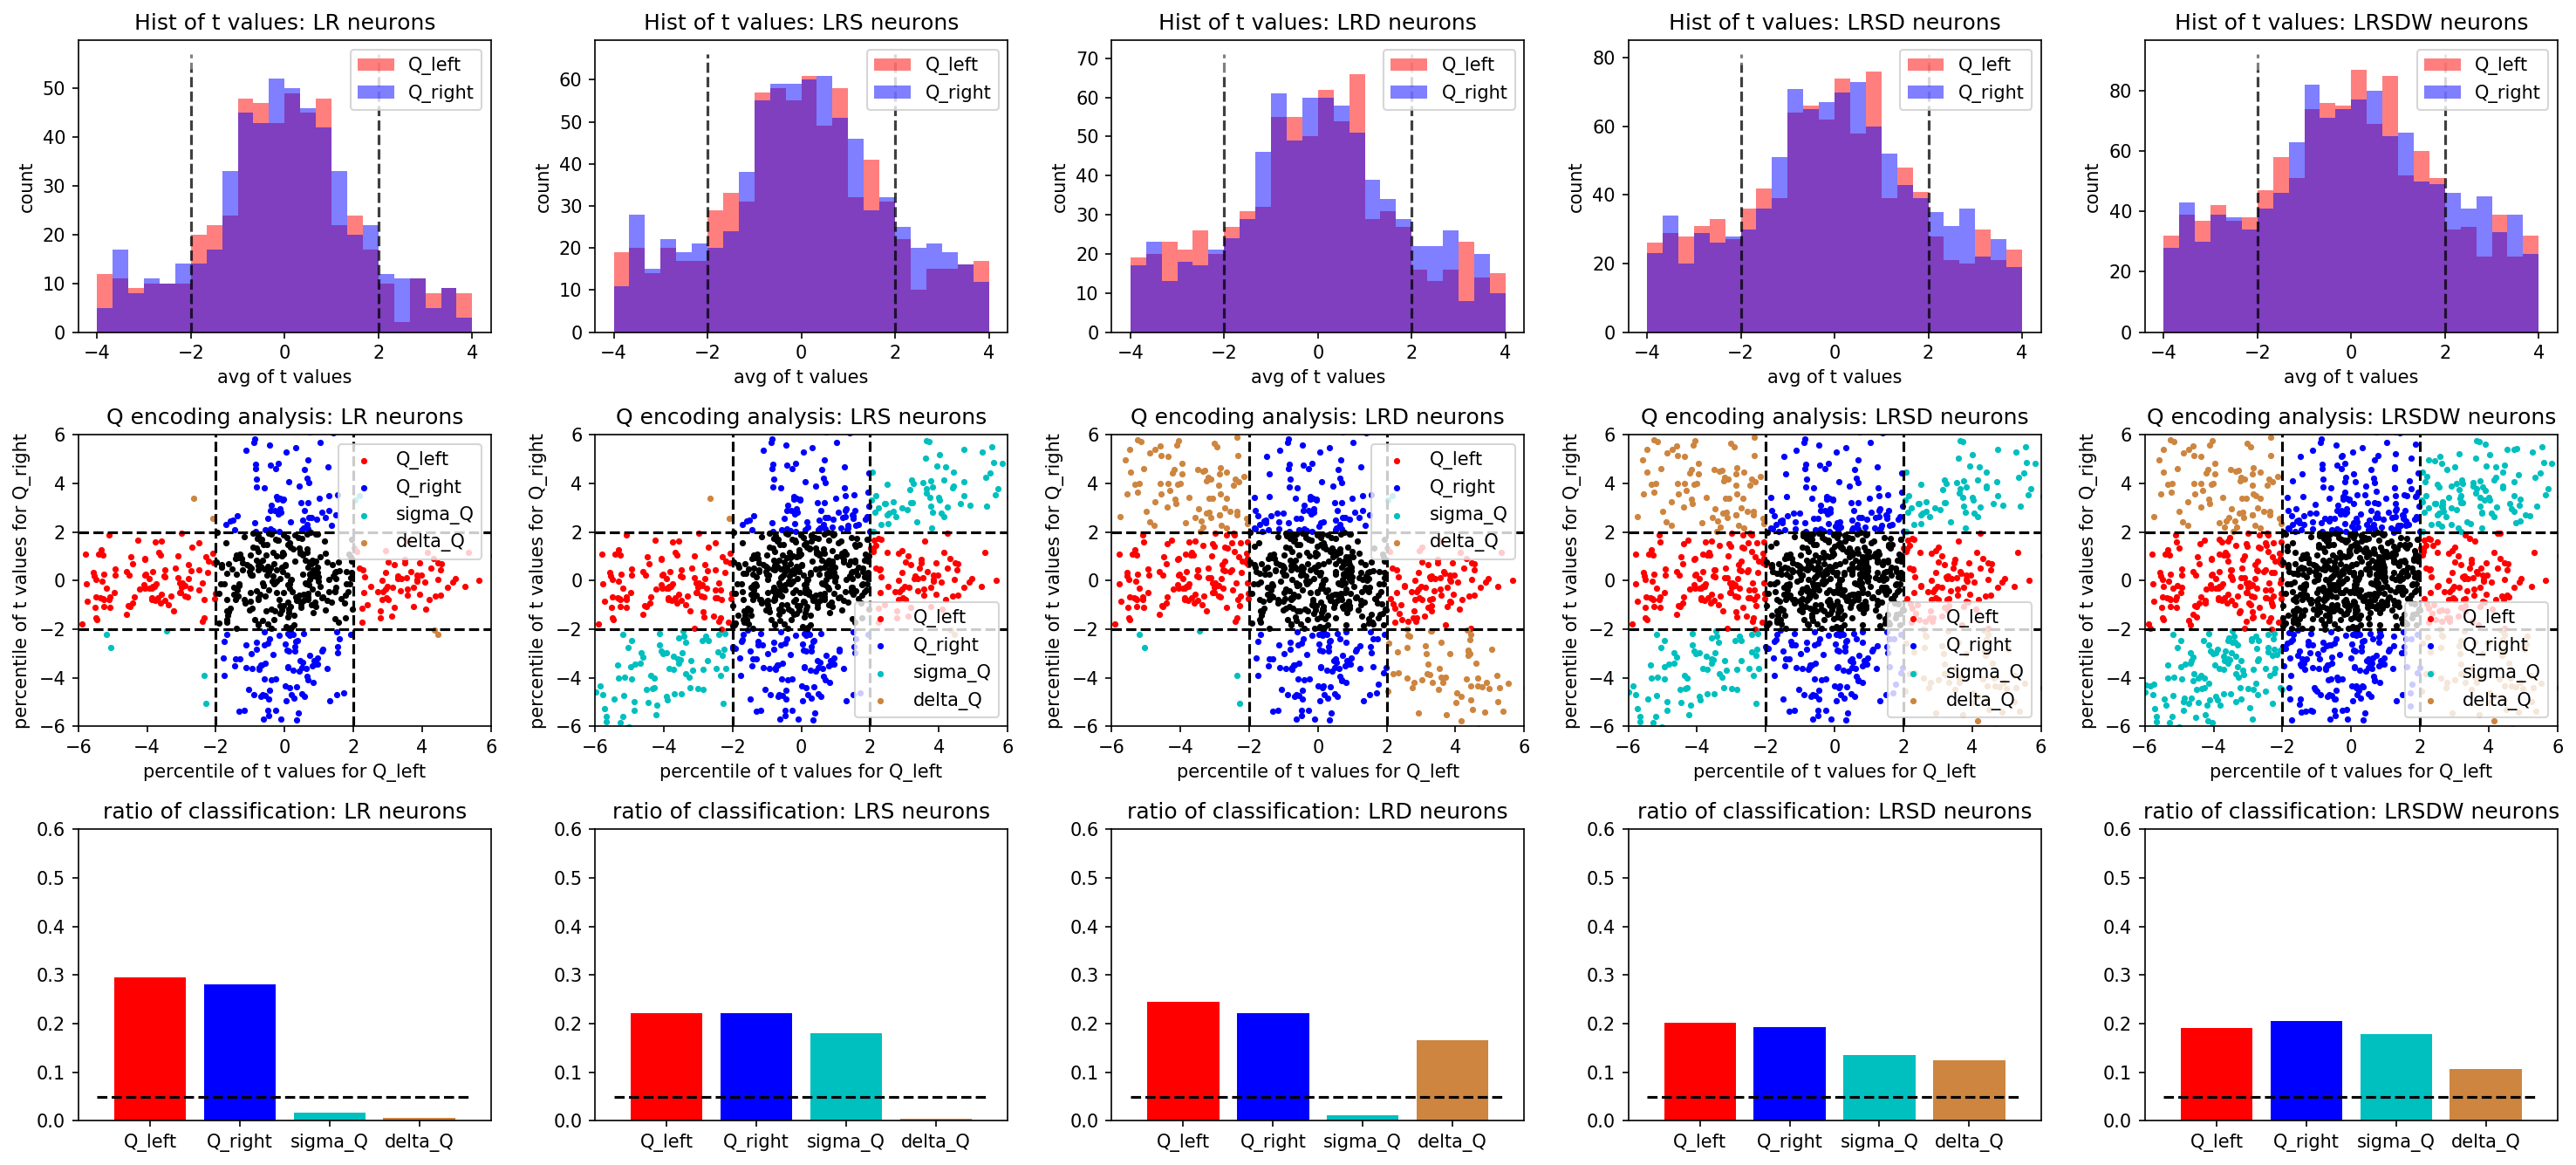

In [47]:
# plot naive fit of pool neurons
percentiles_2_compute = [2.5, 97.5]

colors = {'Q_left': 'r', 'Q_right': 'b'}
hist_lim = (-4, 4)
hist_top = 40

tvalue_lim = (-6, 6)
tvalue_sig_thresh = (-2, 2)
dot_size = 6

classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(3, len(pool_types), figsize=(4*len(pool_types), 3*3), dpi=150)
for pool_type_id, pool_type in enumerate(pool_types):
    col_ind = pool_type_id

    df_fit = df_naive_fit_pool_dict[pool_type]
    tvalues_percentile = {'Q_left': None, 'Q_right': None}
    # histogram of regression tvalues
    row_ind = 0
    for i, q_side in enumerate(['Q_left', 'Q_right']):
        tvalues_q_side = df_fit[f'tvalues_{q_side}'].values
        tvalues_percentile_q_side = np.percentile(tvalues_q_side, percentiles_2_compute)
        tvalues_percentile[q_side] = tvalues_percentile_q_side
        hist_q_side, _, _ = axs[row_ind, col_ind].hist(tvalues_q_side, bins=24, range=hist_lim, histtype='stepfilled', 
                                                       color=colors[q_side], label=q_side, alpha=0.5)
        axs[row_ind, col_ind].vlines(tvalue_sig_thresh, 0, np.max(hist_q_side)+5, 
                                     color='k', linestyle='--', alpha=0.5)
        #axs[row_ind, col_ind].vlines(tvalues_percentile_q_side, 0, hist_top, 
        #                             color=colors[q_side], linestyle='--', alpha=0.5)

    axs[row_ind, col_ind].set_title(f'Hist of t values: {pool_type} neurons')
    axs[row_ind, col_ind].set_xlabel('t value')
    axs[row_ind, col_ind].set_ylabel('count')
    axs[row_ind, col_ind].legend()

    
    # scatter plot of neurons
    row_ind = 1
    # choose tvalue_sig_threshold
    # (-2, 2) for naive case
    tvalue_sig_threshold = {'Q_left': tvalue_sig_thresh, 'Q_right': tvalue_sig_thresh} 
    # dynamic for adv analysis
    # tvalue_sig_threshold = {'Q_left': tvalues_percentile['Q_left'], 'Q_right': tvalues_percentile['Q_right']} 
    df_fit_Q_left_sig = df_fit[((df_fit['tvalues_Q_left']>=tvalue_sig_threshold['Q_left'][1]) | 
                                (df_fit['tvalues_Q_left']<=tvalue_sig_threshold['Q_left'][0])) & 
                               (df_fit['tvalues_Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                               (df_fit['tvalues_Q_right']>tvalue_sig_threshold['Q_right'][0])]
    axs[row_ind, col_ind].scatter(df_fit_Q_left_sig['tvalues_Q_left'].values, 
                                  df_fit_Q_left_sig['tvalues_Q_right'].values, 
                                  color='r', s=dot_size, label='Q_left')
    df_fit_Q_right_sig = df_fit[((df_fit['tvalues_Q_right']>=tvalue_sig_threshold['Q_right'][1]) | 
                                 (df_fit['tvalues_Q_right']<=tvalue_sig_threshold['Q_right'][0])) & 
                                (df_fit['tvalues_Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                                (df_fit['tvalues_Q_left']>tvalue_sig_threshold['Q_left'][0])]
    axs[row_ind, col_ind].scatter(df_fit_Q_right_sig['tvalues_Q_left'].values, 
                                  df_fit_Q_right_sig['tvalues_Q_right'].values, 
                                  color='b', s=dot_size, label='Q_right')
    df_fit_sigma_Q_sig = df_fit[((df_fit['tvalues_Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit['tvalues_Q_right']>=tvalue_sig_threshold['Q_right'][1])) | 
                                ((df_fit['tvalues_Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit['tvalues_Q_right']<=tvalue_sig_threshold['Q_right'][0]))]
    axs[row_ind, col_ind].scatter(df_fit_sigma_Q_sig['tvalues_Q_left'].values, 
                                  df_fit_sigma_Q_sig['tvalues_Q_right'].values, 
                                  color='c', s=dot_size, label='sigma_Q')
    df_fit_delta_Q_sig = df_fit[((df_fit['tvalues_Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit['tvalues_Q_right']<=tvalue_sig_threshold['Q_right'][0])) | 
                                ((df_fit['tvalues_Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit['tvalues_Q_right']>=tvalue_sig_threshold['Q_right'][1]))]
    axs[row_ind, col_ind].scatter(df_fit_delta_Q_sig['tvalues_Q_left'].values, 
                                  df_fit_delta_Q_sig['tvalues_Q_right'].values, 
                                  color='peru', s=dot_size, label='delta_Q')
    df_fit_null = df_fit[(df_fit['tvalues_Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                         (df_fit['tvalues_Q_left']>tvalue_sig_threshold['Q_left'][0]) & 
                         (df_fit['tvalues_Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                         (df_fit['tvalues_Q_right']>tvalue_sig_threshold['Q_right'][0])]
    axs[row_ind, col_ind].scatter(df_fit_null['tvalues_Q_left'].values, 
                                  df_fit_null['tvalues_Q_right'].values, 
                                  color='k', s=dot_size)
    sum_classified_neurons = len(df_fit_Q_left_sig)+len(df_fit_Q_right_sig)+ \
                             len(df_fit_sigma_Q_sig)+len(df_fit_delta_Q_sig)+ \
                             len(df_fit_null)
    if len(df_fit) != sum_classified_neurons:
        raise ValueError(f'sum of dots doesnt match: {len(df_fit)} {sum_classified_neurons}')

    axs[row_ind, col_ind].hlines(tvalue_sig_thresh, tvalue_lim[0], tvalue_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].vlines(tvalue_sig_thresh, tvalue_lim[0], tvalue_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'Q encoding analysis: {pool_type} neurons')
    axs[row_ind, col_ind].set_xlim(tvalue_lim[0], tvalue_lim[1])
    axs[row_ind, col_ind].set_ylim(tvalue_lim[0], tvalue_lim[1])
    axs[row_ind, col_ind].set_xlabel('percentile of t values for Q_left')
    axs[row_ind, col_ind].set_ylabel('percentile of t values for Q_right')
    axs[row_ind, col_ind].legend()


    # bar plot for significant neurons
    row_ind=2
    
    print(f'{neuron_type} total dots: {len(df_fit)}')
    print(f' classified Q_left: {len(df_fit_Q_left_sig)}')
    print(f' classified Q_right: {len(df_fit_Q_right_sig)}')
    print(f' classified sigma_Q: {len(df_fit_sigma_Q_sig)}')
    print(f' classified delta_Q: {len(df_fit_delta_Q_sig)}')
    classified_ratios = [
        len(df_fit_Q_left_sig)/ float(len(df_fit)),
        len(df_fit_Q_right_sig)/ float(len(df_fit)),
        len(df_fit_sigma_Q_sig)/ float(len(df_fit)),
        len(df_fit_delta_Q_sig)/ float(len(df_fit))]
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of classification: {pool_type} neurons')
    axs[row_ind, col_ind].set_ylim(0, 0.5)

plt.tight_layout()

In [19]:
# ps fit, single neuron encoding
# compute the test statistic: t values of regression with q generation
# generating pseudo sessions (pseudo Qs)
n_pseudo_sessions = 120

# pseudo_session fit
ps_encode_columns = ['gen_session', 'neuron_id', 'fit_session', 'tvalues_Q_left', 'tvalues_Q_right']
# if fit_session<0: fit on pseudo sessions
df_ps_encode_dict = {neuron_type: pd.DataFrame(columns=ps_encode_columns) for neuron_type in neuron_types}

# fit simulated neurons on pseudo_sessions
for neuron_type in neuron_types:
    print(f'neuron type {neuron_type}')
    neurons = sim_neurons[neuron_type]
    sessions_with_unit = np.unique(neurons['session'].values)

    df_ps_fit = df_ps_encode_dict[neuron_type]

    for session in sessions_with_unit:
        # get session history
        key = {'subject_id': 482353, 'session': session, 'model_id': 10}
        choice_history, reward_history, _, p_reward_trial, q_choice_outcome = foraging_model.get_session_history(key, remove_ignored=True)
        p_reward_block_df = pd.DataFrame((experiment.SessionBlock.WaterPortRewardProbability() & key).fetch())
        p_reward_block_left = p_reward_block_df[p_reward_block_df['water_port']=='left'].sort_values(by='block')['reward_probability'].values
        p_reward_block_right = p_reward_block_df[p_reward_block_df['water_port']=='right'].sort_values(by='block')['reward_probability'].values
        p_reward_block = np.vstack((p_reward_block_left, p_reward_block_right)).astype(np.float)
        block_lengths, _ = get_block_lengths(p_reward_trial, p_reward_block)
    
        
        #for n in range(len(neurons)):
        for n in range(10):
            
            # fit true sessions
            df_Qs_session = df_Qs[df_Qs['session']==session].sort_values(by=['trial'])
            X = df_Qs_session[['Q_left', 'Q_right']]
            X = sm.add_constant(X)

            fr = neurons[(neurons['session']==session) & (neurons['neuron_id']==n)]['firing_rates'].values[0]
            model = sm.OLS(fr, X)
            results = model.fit()
            df_ps_fit.loc[len(df_ps_fit.index)] = [session, n, session, results.tvalues['Q_left'], results.tvalues['Q_right']]

            # fit pseudo sessions
            for j in range(n_pseudo_sessions):
                X = gen_qs_by_fitted_model(key, p_reward_trial, p_reward_block, block_lengths).T[:-1, :]
                #print(f'pseudo session {j} generated')
                X = sm.add_constant(X)
                model = sm.OLS(fr, X)
                results = model.fit()
                #print(f'pseudo session {j} fitted')
                df_ps_fit.loc[len(df_ps_fit.index)] = [session, n, -1*(j+1), results.tvalues[1], results.tvalues[2]]
        print(f'end of neuron type {neuron_type}')
        
    print(f'end of session {session}: {X.shape}')

simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
end of neuron type Q_left
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
end of neuron type Q_right
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forager
simulating forag

Q_left total dots: 120
 classified Q_left: 82
 classified Q_right: 1
 classified sigma_Q: 2
 classified delta_Q: 1
Q_right total dots: 120
 classified Q_left: 4
 classified Q_right: 75
 classified sigma_Q: 2
 classified delta_Q: 3
sigma_Q total dots: 120
 classified Q_left: 19
 classified Q_right: 6
 classified sigma_Q: 62
 classified delta_Q: 0
delta_Q total dots: 120
 classified Q_left: 14
 classified Q_right: 10
 classified sigma_Q: 0
 classified delta_Q: 78
rw total dots: 120
 classified Q_left: 7
 classified Q_right: 0
 classified sigma_Q: 0
 classified delta_Q: 0


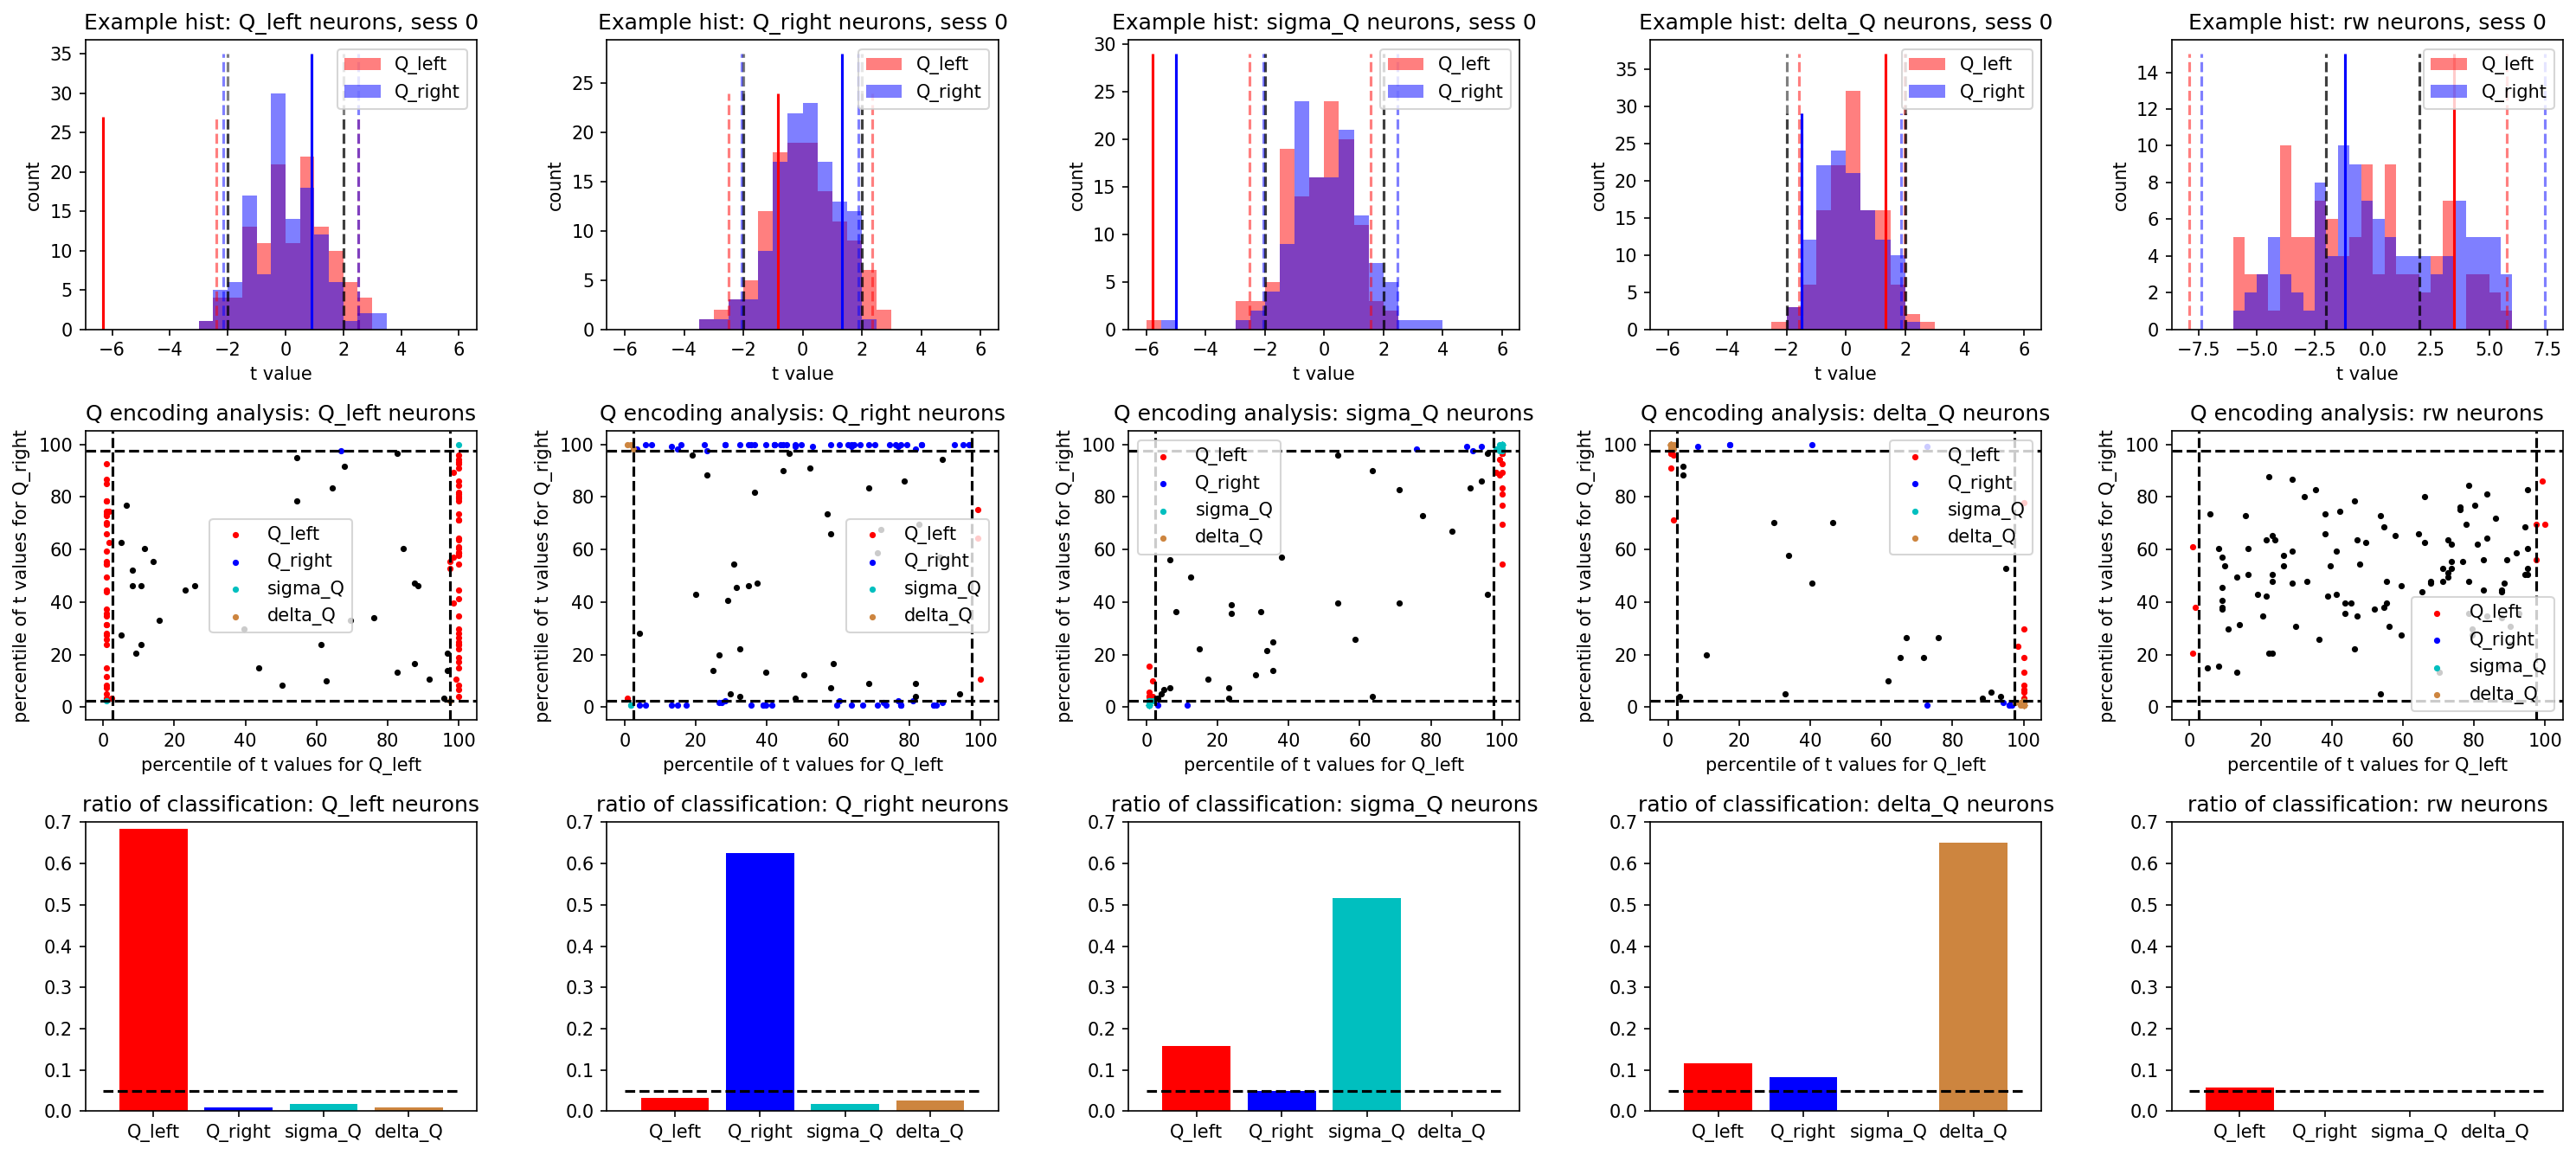

In [4]:
with open('./df_ps_fit_dict_sess_42_n_120_ps_120.pickle', 'rb') as handle:
    df_ps_fit_dict = pickle.load(handle)

tvalue_sig_thresh = (-2, 2)
neuron_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q', 'rw']

# plot psuedo_session fit
percentiles_2_compute = [2.5, 97.5]

hist_lim = (-6, 6)
hist_to_plot_neuron_id = 0
colors = {'Q_left': 'r', 'Q_right': 'b'}

tvalue_percentile_lim = (-5, 105)
dot_size = 6

classified_types = ['Q_left', 'Q_right', 'sigma_Q', 'delta_Q']
bar_colors = ['r', 'b', 'c', 'peru']


fig, axs = plt.subplots(3, len(neuron_types), figsize=(4*len(neuron_types), 3*3), dpi=150)
for neuron_type_id, neuron_type in enumerate(neuron_types):
    col_ind = neuron_type_id
    df_fit = df_ps_encode_dict[neuron_type]
    
    # calculate percentile of t values of self-fitted sessions
    # based on the ensemble of pseudo sessions
    n_neurons_fitted = len(np.unique(df_fit['neuron_id'].values))
    df_fit_t_percentile_agnt_null = pd.DataFrame(columns=['neuron_id', 'Q_left', 'Q_right'])

    for n in np.unique(df_fit['neuron_id'].values).astype(np.int):
        df_fit_neuron = df_fit[df_fit['neuron_id']==n]
        t_percentile_agnt_null = [n]
        for i, q_side in enumerate(['Q_left', 'Q_right']):
            tvalues_q_side = df_fit_neuron[f'tvalues_{q_side}'].values
            # get self fitted t values
            tvalue_self_q_side = df_fit_neuron[df_fit_neuron['gen_session']==df_fit_neuron['fit_session']][f'tvalues_{q_side}'].iloc[0]
            
            t_percentile_agnt_null.append(stats.percentileofscore(tvalues_q_side, tvalue_self_q_side))

            # histogram of regression tvalues
            if n == hist_to_plot_neuron_id:
                row_ind = 0
                tvalues_percentile_q_side = np.percentile(tvalues_q_side, percentiles_2_compute)
                hist_q_side, _, _ = axs[row_ind, col_ind].hist(tvalues_q_side, bins=24, range=hist_lim, histtype='stepfilled', 
                                                               color=colors[q_side], label=q_side, alpha=0.5)
                axs[row_ind, col_ind].vlines(tvalue_self_q_side, 0, np.max(hist_q_side)+5, 
                                             color=colors[q_side])
                axs[row_ind, col_ind].vlines(tvalues_percentile_q_side, 0, np.max(hist_q_side)+5, 
                                             color=colors[q_side], linestyle='--', alpha=0.5)
                axs[row_ind, col_ind].vlines(tvalue_sig_thresh, 0, np.max(hist_q_side)+5, 
                                            color='k', linestyle='--', alpha=0.5)
                axs[row_ind, col_ind].set_title(f'Example hist: {neuron_type} neurons {n}')
                axs[row_ind, col_ind].set_xlabel('t value')
                axs[row_ind, col_ind].set_ylabel('count')
                axs[row_ind, col_ind].legend()

        df_fit_t_percentile_agnt_null.loc[len(df_fit_t_percentile_agnt_null.index)] = t_percentile_agnt_null
        
    
    # scatter plot of neurons
    row_ind = 1
    
    # choose tvalue_sig_threshold
    # (-2, 2) for naive case
    # tvalue_sig_threshold = {'Q_left': tvalue_sig_thresh, 'Q_right': tvalue_sig_thresh} 
    # dynamic for adv analysis
    # tvalue_sig_threshold = {'Q_left': tvalues_percentile['Q_left'], 'Q_right': tvalues_percentile['Q_right']} 
    # (2.5, 97.5) for percentile case
    tvalue_sig_threshold = {'Q_left': percentiles_2_compute, 'Q_right': percentiles_2_compute} 
    
    df_fit_Q_left_sig = df_fit_t_percentile_agnt_null[((df_fit_t_percentile_agnt_null['Q_left']>=tvalue_sig_threshold['Q_left'][1]) | 
                                (df_fit_t_percentile_agnt_null['Q_left']<=tvalue_sig_threshold['Q_left'][0])) & 
                               (df_fit_t_percentile_agnt_null['Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                               (df_fit_t_percentile_agnt_null['Q_right']>tvalue_sig_threshold['Q_right'][0])]
    axs[row_ind, col_ind].scatter(df_fit_Q_left_sig['Q_left'].values, 
                                  df_fit_Q_left_sig['Q_right'].values, 
                                  color='r', s=dot_size, label='Q_left')
    df_fit_Q_right_sig = df_fit_t_percentile_agnt_null[((df_fit_t_percentile_agnt_null['Q_right']>=tvalue_sig_threshold['Q_right'][1]) | 
                                 (df_fit_t_percentile_agnt_null['Q_right']<=tvalue_sig_threshold['Q_right'][0])) & 
                                (df_fit_t_percentile_agnt_null['Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                                (df_fit_t_percentile_agnt_null['Q_left']>tvalue_sig_threshold['Q_left'][0])]
    axs[row_ind, col_ind].scatter(df_fit_Q_right_sig['Q_left'].values, 
                                  df_fit_Q_right_sig['Q_right'].values, 
                                  color='b', s=dot_size, label='Q_right')
    df_fit_sigma_Q_sig = df_fit_t_percentile_agnt_null[((df_fit_t_percentile_agnt_null['Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']>=tvalue_sig_threshold['Q_right'][1])) | 
                                ((df_fit_t_percentile_agnt_null['Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']<=tvalue_sig_threshold['Q_right'][0]))]
    axs[row_ind, col_ind].scatter(df_fit_sigma_Q_sig['Q_left'].values, 
                                  df_fit_sigma_Q_sig['Q_right'].values, 
                                  color='c', s=dot_size, label='sigma_Q')
    df_fit_delta_Q_sig = df_fit_t_percentile_agnt_null[((df_fit_t_percentile_agnt_null['Q_left']>=tvalue_sig_threshold['Q_left'][1]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']<=tvalue_sig_threshold['Q_right'][0])) | 
                                ((df_fit_t_percentile_agnt_null['Q_left']<=tvalue_sig_threshold['Q_left'][0]) & 
                                 (df_fit_t_percentile_agnt_null['Q_right']>=tvalue_sig_threshold['Q_right'][1]))]
    axs[row_ind, col_ind].scatter(df_fit_delta_Q_sig['Q_left'].values, 
                                  df_fit_delta_Q_sig['Q_right'].values, 
                                  color='peru', s=dot_size, label='delta_Q')
    df_fit_null = df_fit_t_percentile_agnt_null[(df_fit_t_percentile_agnt_null['Q_left']<tvalue_sig_threshold['Q_left'][1]) & 
                         (df_fit_t_percentile_agnt_null['Q_left']>tvalue_sig_threshold['Q_left'][0]) & 
                         (df_fit_t_percentile_agnt_null['Q_right']<tvalue_sig_threshold['Q_right'][1]) & 
                         (df_fit_t_percentile_agnt_null['Q_right']>tvalue_sig_threshold['Q_right'][0])]
    axs[row_ind, col_ind].scatter(df_fit_null['Q_left'].values, 
                                  df_fit_null['Q_right'].values, 
                                  color='k', s=dot_size)
    sum_classified_neurons = len(df_fit_Q_left_sig)+len(df_fit_Q_right_sig)+ \
                             len(df_fit_sigma_Q_sig)+len(df_fit_delta_Q_sig)+ \
                             len(df_fit_null)
    if len(df_fit_t_percentile_agnt_null) != sum_classified_neurons:
        raise ValueError(f'sum of dots doesnt match: {len(df_fit_t_percentile_agnt_null)} {sum_classified_neurons}')

    axs[row_ind, col_ind].hlines(tvalue_sig_threshold['Q_left'], tvalue_percentile_lim[0], tvalue_percentile_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].vlines(tvalue_sig_threshold['Q_left'], tvalue_percentile_lim[0], tvalue_percentile_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'Q encoding analysis: {neuron_type} neurons')
    axs[row_ind, col_ind].set_xlim(tvalue_percentile_lim[0], tvalue_percentile_lim[1])
    axs[row_ind, col_ind].set_ylim(tvalue_percentile_lim[0], tvalue_percentile_lim[1])
    axs[row_ind, col_ind].set_xlabel('percentile of t values for Q_left')
    axs[row_ind, col_ind].set_ylabel('percentile of t values for Q_right')
    axs[row_ind, col_ind].legend()


    # bar plot for significant neurons
    row_ind = 2
    print(f'{neuron_type} total dots: {len(df_fit_t_percentile_agnt_null)}')
    print(f' classified Q_left: {len(df_fit_Q_left_sig)}')
    print(f' classified Q_right: {len(df_fit_Q_right_sig)}')
    print(f' classified sigma_Q: {len(df_fit_sigma_Q_sig)}')
    print(f' classified delta_Q: {len(df_fit_delta_Q_sig)}')
    
    classified_ratios = [
        len(df_fit_Q_left_sig)/ float(len(df_fit_t_percentile_agnt_null)),
        len(df_fit_Q_right_sig)/ float(len(df_fit_t_percentile_agnt_null)),
        len(df_fit_sigma_Q_sig)/ float(len(df_fit_t_percentile_agnt_null)),
        len(df_fit_delta_Q_sig)/ float(len(df_fit_t_percentile_agnt_null))]
    axs[row_ind, col_ind].bar(classified_types, classified_ratios, color=bar_colors)
    x_lim = axs[row_ind, col_ind].get_xlim()
    axs[row_ind, col_ind].hlines(0.05, x_lim[0], x_lim[1], color='k', linestyle='--')
    axs[row_ind, col_ind].set_title(f'ratio of classification: {neuron_type} neurons')
    axs[row_ind, col_ind].set_ylim(0, 0.7)

plt.tight_layout()